### 데이터사이언스융합학과 2024710658 박창준

# Google Colab amount

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### 패키치 설치 및 불러오기

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

C:\Dev\miniconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


데이터 출처 : https://dacon.io/competitions/official/235713/data

### 변수 설명
- index : index
- gender: 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류
        ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
- edu_type: 교육 수준
        ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
- family_type: 결혼 여부
        ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

- house_type: 생활 방식
        ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']

- DAYS_BIRTH: 출생일
    - 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미

- DAYS_EMPLOYED: 업무 시작일
    - 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
    - 양수 값은 고용되지 않은 상태를 의미함
- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형
- family_size: 가족 규모
- begin_month: 신용카드 발급 월
    - 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
- credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
    - 낮을 수록 높은 신용의 신용카드 사용자를 의미함

### Data Load

In [3]:
df = pd.read_csv("D:/박창준 문서/4. 대학교육/2. 성균관대학교 일반대학원/Code/Credit_Card_Members.csv")

In [4]:
# 2진분류로 변경
df['credit'] = np.where(df['credit'] == 2, 1, 0)

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['credit'])  # 종속 변수를 제외한 모든 독립 변수들
y = df['credit']  # 종속 변수

In [6]:
# 실험
y = pd.concat([y[y != 1], y[y == 1][:1600]], axis = 0)
df = pd.merge(y.to_frame(), X, left_index=True, right_index=True)


In [7]:
# 실험
y = pd.concat([y[y != 2], y[y == 2][:1600]], axis = 0)
df = pd.merge(y.to_frame(), X, left_index=True, right_index=True)

X = df.drop(columns=['credit'])  # 종속 변수를 제외한 모든 독립 변수들
y = df['credit']  # 종속 변수

# train과 test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle = True)

In [8]:
train = pd.concat([X_train, y_train], axis=1)
# 인덱스를 다시 설정
train.reset_index(drop=True, inplace=True)

In [9]:
test = pd.concat([X_test, y_test], axis=1)
# 인덱스를 다시 설정
test.reset_index(drop=True, inplace=True)

In [10]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,10309,F,N,N,0,157500.0,Commercial associate,Higher education,Separated,With parents,-15737,-432,1,0,0,0,NaN,1.0,-14.0,0
1,23580,M,Y,N,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-14209,-97,1,0,0,0,Security staff,2.0,-11.0,0
2,5046,F,N,Y,0,360000.0,Commercial associate,Higher education,Married,House / apartment,-11089,-3902,1,0,1,0,Core staff,2.0,-7.0,0
3,408,F,N,Y,0,135000.0,Working,Lower secondary,Civil marriage,House / apartment,-15143,-991,1,0,0,0,Laborers,2.0,-27.0,1
4,10230,F,N,Y,1,121500.0,Working,Higher education,Married,House / apartment,-11981,-2965,1,1,0,0,Accountants,3.0,-46.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8866,1613,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-23774,365243,1,0,0,0,NaN,1.0,-22.0,1
8867,1545,F,N,Y,0,112500.0,Working,Higher education,Single / not married,House / apartment,-14446,-3161,1,0,0,0,NaN,1.0,-14.0,1
8868,2411,M,N,Y,1,126000.0,Working,Secondary / secondary special,Married,House / apartment,-13386,-1708,1,0,0,1,Drivers,3.0,-8.0,0
8869,54,F,N,N,1,99000.0,Working,Secondary / secondary special,Married,House / apartment,-15626,-422,1,0,0,0,NaN,3.0,-2.0,0


In [11]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,12158,M,N,N,1,225000.0,Working,Higher education,Married,House / apartment,-18093,-2493,1,0,0,0,Managers,3.0,-38.0,0
1,14812,M,Y,Y,4,157500.0,Working,Higher education,Married,House / apartment,-11380,-1734,1,0,0,0,Managers,6.0,-34.0,0
2,14386,F,N,Y,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-18199,-5190,1,0,0,0,Cleaning staff,2.0,-59.0,0
3,26286,M,Y,Y,0,225000.0,Commercial associate,Higher education,Single / not married,House / apartment,-9220,-1473,1,0,0,0,Core staff,1.0,-5.0,0
4,15344,F,N,N,1,135000.0,State servant,Higher education,Married,House / apartment,-9454,-1022,1,1,0,0,Managers,3.0,-19.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,7423,F,Y,N,0,202500.0,Working,Higher education,Married,House / apartment,-9242,-139,1,0,0,0,Accountants,2.0,-9.0,0
2214,17635,M,Y,Y,1,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-17237,-1710,1,0,0,0,Managers,3.0,-46.0,0
2215,278,F,N,Y,0,180000.0,Working,Higher education,Married,House / apartment,-14083,-7049,1,1,0,0,Core staff,2.0,0.0,0
2216,12331,F,N,N,0,67500.0,Working,Secondary / secondary special,Married,With parents,-16182,-2827,1,1,1,0,Cooking staff,2.0,-48.0,0


### EDA & Preprocessing

1) 개형 확인

In [12]:
train.shape

(8871, 20)

In [13]:
test.shape

(2218, 20)

2) 컬럼별 자료형 확인

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8871 entries, 0 to 8870
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          8871 non-null   int64  
 1   gender         8871 non-null   object 
 2   car            8871 non-null   object 
 3   reality        8871 non-null   object 
 4   child_num      8871 non-null   int64  
 5   income_total   8871 non-null   float64
 6   income_type    8871 non-null   object 
 7   edu_type       8871 non-null   object 
 8   family_type    8871 non-null   object 
 9   house_type     8871 non-null   object 
 10  DAYS_BIRTH     8871 non-null   int64  
 11  DAYS_EMPLOYED  8871 non-null   int64  
 12  FLAG_MOBIL     8871 non-null   int64  
 13  work_phone     8871 non-null   int64  
 14  phone          8871 non-null   int64  
 15  email          8871 non-null   int64  
 16  occyp_type     6145 non-null   object 
 17  family_size    8871 non-null   float64
 18  begin_mo

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2218 non-null   int64  
 1   gender         2218 non-null   object 
 2   car            2218 non-null   object 
 3   reality        2218 non-null   object 
 4   child_num      2218 non-null   int64  
 5   income_total   2218 non-null   float64
 6   income_type    2218 non-null   object 
 7   edu_type       2218 non-null   object 
 8   family_type    2218 non-null   object 
 9   house_type     2218 non-null   object 
 10  DAYS_BIRTH     2218 non-null   int64  
 11  DAYS_EMPLOYED  2218 non-null   int64  
 12  FLAG_MOBIL     2218 non-null   int64  
 13  work_phone     2218 non-null   int64  
 14  phone          2218 non-null   int64  
 15  email          2218 non-null   int64  
 16  occyp_type     1539 non-null   object 
 17  family_size    2218 non-null   float64
 18  begin_mo

3) target (credit 컬럼) 확인

In [16]:
train['credit'].value_counts()

credit
0    7591
1    1280
Name: count, dtype: int64

In [17]:
train['credit'].value_counts(normalize=True)

credit
0    0.85571
1    0.14429
Name: proportion, dtype: float64

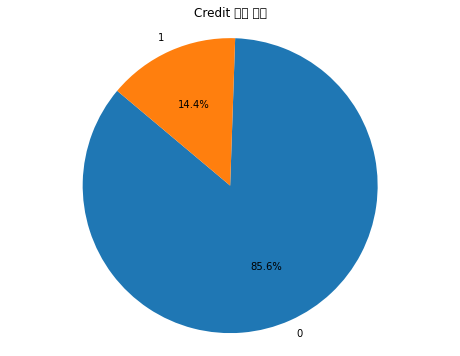

In [18]:
import matplotlib.pyplot as plt

# credit 컬럼의 값 빈도 계산
credit_counts = train['credit'].value_counts()

# 시각화
plt.figure(figsize=(8, 6))
plt.pie(credit_counts, labels=credit_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Credit 구성 비율')
plt.axis('equal')  # 원 그래프를 동그랗게 만듦
plt.show()

4)  Numeric column, Categorical column 나누기

In [19]:
# 1. dtype으로 나누기
numerical_list = []
categorical_list = []

for col, dtype in train.dtypes.items() : 
    if dtype == 'object' : 
        categorical_list.append(col)
    else :
        numerical_list.append(col)

In [20]:
# 2. 수기로 추가하기 (이미 숫자로 인코딩되어 표현된 경우)
add_categoric = ['FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size', 'credit']

for i in add_categoric : 
    numerical_list.remove(i)
    
for i in add_categoric : 
    categorical_list.append(i)

In [21]:
print(numerical_list)
print(categorical_list)

['index', 'child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size', 'credit']


4) 컬럼별 이상치분석

- Numerical Data

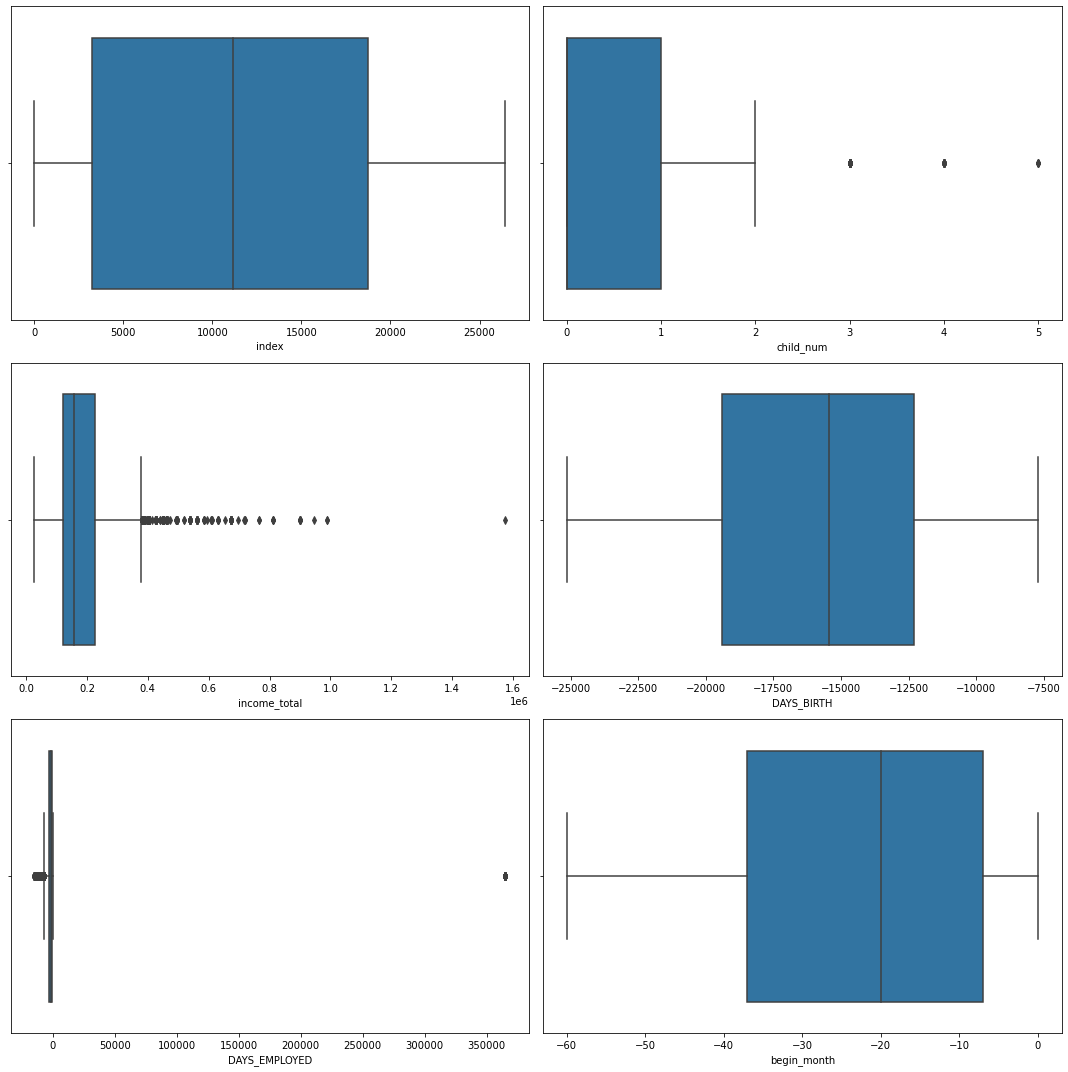

In [22]:
def visualize_outliers_iqr(df, columns):
    num_cols = len(columns)
    fig, axes = plt.subplots(num_cols // 2, 2, figsize=(15, 15))
    for i, col in enumerate(columns):
        row = i // 2
        col = i % 2
        Q1 = df[columns[i]].quantile(0.25)  # 수정 필요: df[col] -> df[columns[i]]
        Q3 = df[columns[i]].quantile(0.75)  # 수정 필요: df[col] -> df[columns[i]]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[((df[columns[i]] < lower_bound) | (df[columns[i]] > upper_bound))]
        sns.boxplot(x=df[columns[i]], ax=axes[row, col])
    plt.tight_layout()
    plt.show()

# 이상치 분석 및 시각화
visualize_outliers_iqr(train, numerical_list)

    (4-1) child_num >= 7인 경우 모두 credit = 2 를 보여줌

In [23]:
train[train['child_num'] >= 7][['child_num', 'credit']]

,child_num,credit


    (4-1) child_num >= 7인 경우 제거

In [24]:
train = train[train['child_num'] < 8]

In [25]:
train[train['child_num'] > 7]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit


    (4-2) DAYS_EMPLOYED == 365243인 컬럼이 train 4,438개이며, 이때의 occyp_type은 전부 'NaN'

In [26]:
train[train['DAYS_EMPLOYED'] == 365243][['DAYS_EMPLOYED', 'occyp_type', 'credit']]

,DAYS_EMPLOYED,occyp_type,credit
9,365243,NaN,0
10,365243,NaN,0
11,365243,NaN,0
17,365243,NaN,0
22,365243,NaN,0
...,...,...,...
8836,365243,NaN,0
8847,365243,NaN,0
8851,365243,NaN,1
8859,365243,NaN,0


    (4-2) DAYS_EMPLOYED == 365243인 컬럼이 df에서는 6,135개

In [27]:
train[train['DAYS_EMPLOYED'] == 365243][['DAYS_EMPLOYED', 'occyp_type']]

,DAYS_EMPLOYED,occyp_type
9,365243,NaN
10,365243,NaN
11,365243,NaN
17,365243,NaN
22,365243,NaN
...,...,...
8836,365243,NaN
8847,365243,NaN
8851,365243,NaN
8859,365243,NaN


    (4-2) 365243일이면 연으로 환산시 1,000년이 넘으므로, 잘못된 값으로 판단.
          DAYS_EMPLOYED == 365243인 컬럼 모두 0으로 변환

In [28]:
train.loc[train['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = 0

In [29]:
train.loc[train['DAYS_EMPLOYED'] == 0, 'DAYS_EMPLOYED']

9       0
10      0
11      0
17      0
22      0
       ..
8836    0
8847    0
8851    0
8859    0
8866    0
Name: DAYS_EMPLOYED, Length: 1546, dtype: int64

- Categorical Data

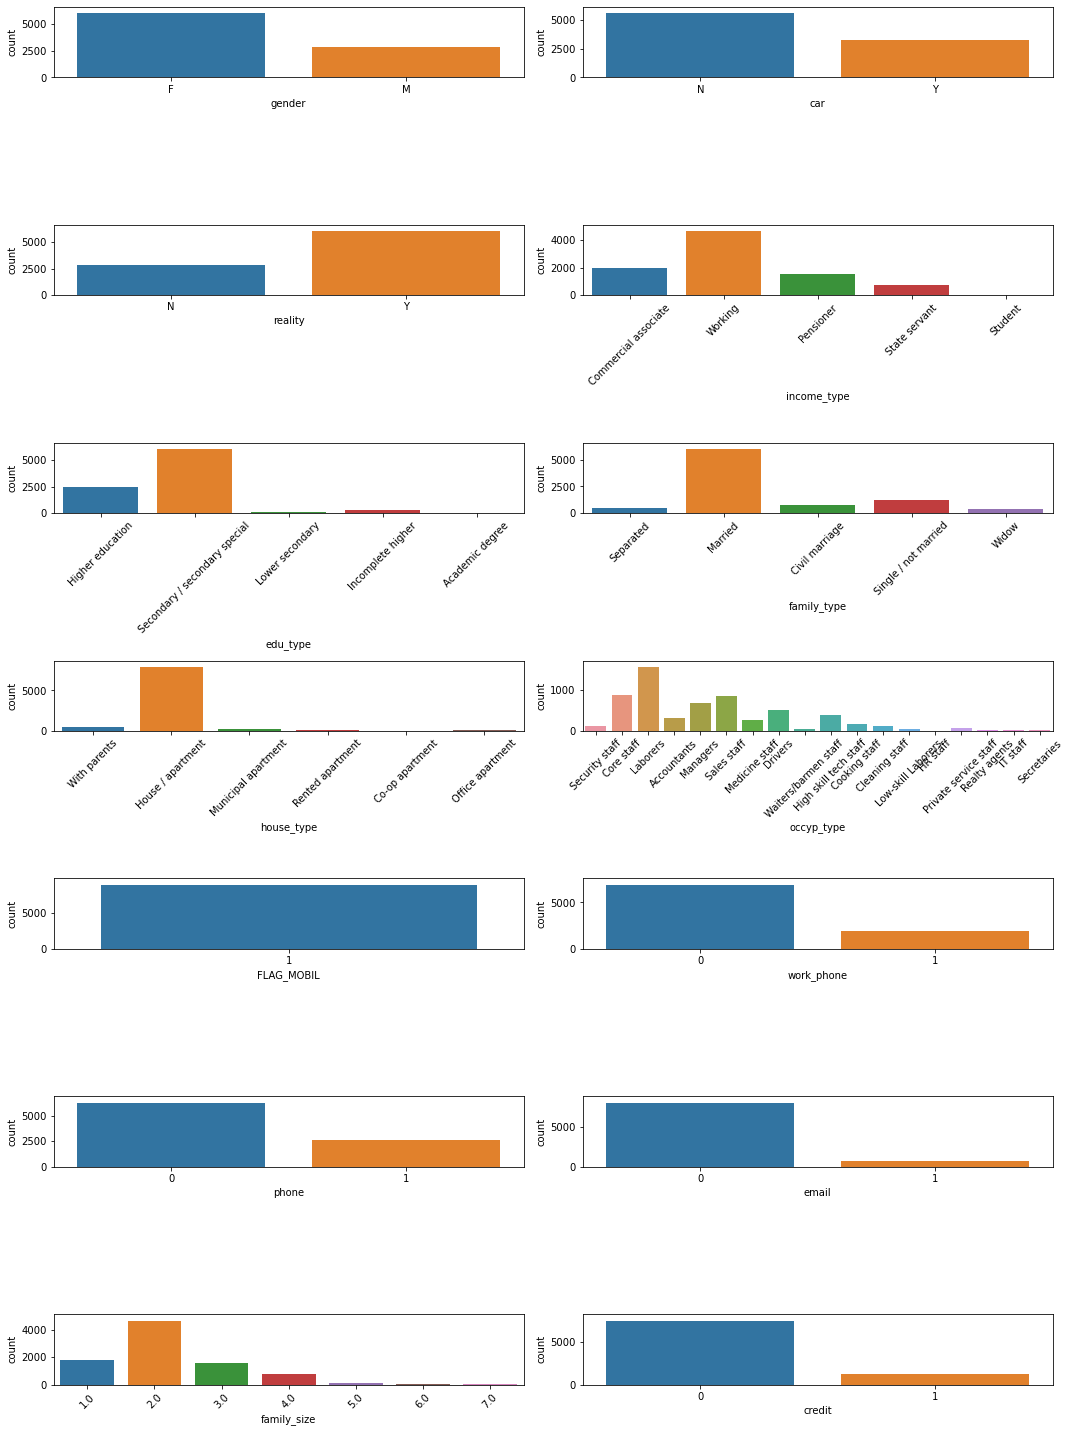

In [30]:
def visualize_categorical(df, columns):
    num_cols = len(columns)
    fig, axes = plt.subplots((num_cols + 1) // 2, 2, figsize=(15, 20))
    for i, col in enumerate(columns):
        row = i // 2
        col = i % 2
        sns.countplot(x=columns[i], data=df, ax=axes[row, col])
        if len(df[columns[i]].unique()) >= 4:
            axes[row, col].tick_params(axis='x', rotation=45)  # x축 눈금 레이블 45도 회전
        axes[row, col].set_ylim(0, df[columns[i]].value_counts().max() * 1.1)  # y축 늘리기
    plt.tight_layout()
    plt.show()

# 카테고리컬 변수 시각화
visualize_categorical(train, categorical_list)

    (4-3) family_size >= 7인 경우 모두 credit = 2 를 보여줌

In [31]:
train[train['family_size'] > 7][['family_size', 'credit']]

,family_size,credit


    (4-3) family_size > 7인 경우 전부 제거

In [32]:
train = train[train['family_size'] < 8]

In [33]:
train[train['family_size'] >= 8]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit


5) 데이터 정확성 확인

In [34]:
train['age'] = (train['DAYS_BIRTH'] * -1) // 365
test['age'] = (test['DAYS_BIRTH'] * -1) // 365

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8871 entries, 0 to 8870
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          8871 non-null   int64  
 1   gender         8871 non-null   object 
 2   car            8871 non-null   object 
 3   reality        8871 non-null   object 
 4   child_num      8871 non-null   int64  
 5   income_total   8871 non-null   float64
 6   income_type    8871 non-null   object 
 7   edu_type       8871 non-null   object 
 8   family_type    8871 non-null   object 
 9   house_type     8871 non-null   object 
 10  DAYS_BIRTH     8871 non-null   int64  
 11  DAYS_EMPLOYED  8871 non-null   int64  
 12  FLAG_MOBIL     8871 non-null   int64  
 13  work_phone     8871 non-null   int64  
 14  phone          8871 non-null   int64  
 15  email          8871 non-null   int64  
 16  occyp_type     6145 non-null   object 
 17  family_size    8871 non-null   float64
 18  begin_mo

    (5-1) 퇴직할 나이가 아닌데도 불구하고 연급 수령을 받는사람 조회

In [36]:
train[(train['income_type'] == 'Pensioner') & (train['occyp_type'].isna()) & (train['age'] < 60)]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
17,21802,F,N,Y,0,202500.0,Pensioner,Higher education,Single / not married,House / apartment,...,0,1,0,1,1,NaN,1.0,-25.0,0,58
30,11933,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,...,0,1,0,1,0,NaN,1.0,-33.0,0,55
39,1474,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,1,0,NaN,2.0,-47.0,1,57
41,1670,F,N,N,0,252000.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,0,1,0,0,0,NaN,2.0,-38.0,1,57
48,10568,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-3.0,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8774,22124,M,Y,Y,0,225000.0,Pensioner,Higher education,Separated,House / apartment,...,0,1,0,0,0,NaN,1.0,-57.0,0,56
8791,13661,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,1,0,NaN,2.0,-1.0,0,59
8829,6177,F,N,Y,0,202500.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-57.0,0,58
8847,20430,F,Y,Y,0,279000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-7.0,0,58


    (5-2) 31세 미만의 Pensioner(연급수급자)는 이상치로 분류하여 삭제

In [37]:
train = train.drop(train[(train['income_type'] == 'Pensioner') & (train['occyp_type'].isna()) & (train['age'] < 31)].index)

In [38]:
# test = test.drop(test[(test['income_type'] == 'Pensioner') & (test['occyp_type'].isna()) & (test['age'] < 31)].index)

In [39]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
0,10309,F,N,N,0,157500.0,Commercial associate,Higher education,Separated,With parents,...,-432,1,0,0,0,NaN,1.0,-14.0,0,43
1,23580,M,Y,N,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,...,-97,1,0,0,0,Security staff,2.0,-11.0,0,38
2,5046,F,N,Y,0,360000.0,Commercial associate,Higher education,Married,House / apartment,...,-3902,1,0,1,0,Core staff,2.0,-7.0,0,30
3,408,F,N,Y,0,135000.0,Working,Lower secondary,Civil marriage,House / apartment,...,-991,1,0,0,0,Laborers,2.0,-27.0,1,41
4,10230,F,N,Y,1,121500.0,Working,Higher education,Married,House / apartment,...,-2965,1,1,0,0,Accountants,3.0,-46.0,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8866,1613,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,...,0,1,0,0,0,NaN,1.0,-22.0,1,65
8867,1545,F,N,Y,0,112500.0,Working,Higher education,Single / not married,House / apartment,...,-3161,1,0,0,0,NaN,1.0,-14.0,1,39
8868,2411,M,N,Y,1,126000.0,Working,Secondary / secondary special,Married,House / apartment,...,-1708,1,0,0,1,Drivers,3.0,-8.0,0,36
8869,54,F,N,N,1,99000.0,Working,Secondary / secondary special,Married,House / apartment,...,-422,1,0,0,0,NaN,3.0,-2.0,0,42


    (5-3) 31세 이상 ~ 60세 미만의 연급수급자는 income_type을 Pensioner_Special로 변경

In [40]:
train.loc[(train['age'] >= 31) & (train['age'] < 60) & (train['income_type'] == 'Pensioner'), 'income_type'] = 'Pensioner_Special'

In [41]:
test.loc[(test['age'] >= 31) & (test['age'] < 60) & (test['income_type'] == 'Pensioner'), 'income_type'] = 'Pensioner_Special'

    (5-4) child_num > 0 이면서 family_type == 'Single / not married인 경우를 확인

In [42]:
train[(train['family_type'] == 'Single / not married') & (train['child_num'] > 0)]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
55,18855,F,N,Y,1,337500.0,Commercial associate,Higher education,Single / not married,House / apartment,...,-431,1,0,0,0,Accountants,2.0,-41.0,0,39
65,1440,F,N,Y,1,90000.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,-2706,1,0,0,0,Laborers,2.0,-18.0,1,32
89,20571,M,N,Y,1,198000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,...,-140,1,0,0,0,Managers,2.0,-29.0,0,26
128,22064,M,N,N,1,99000.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,-5239,1,0,0,0,Laborers,2.0,-1.0,0,48
232,14425,F,N,N,1,112500.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-2452,1,0,0,0,High skill tech staff,2.0,-25.0,0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8618,24155,F,Y,Y,2,180000.0,Working,Higher education,Single / not married,Municipal apartment,...,-3019,1,0,0,0,Laborers,3.0,-14.0,0,28
8650,24870,F,Y,N,1,112500.0,Working,Higher education,Single / not married,House / apartment,...,-1618,1,0,0,0,Core staff,2.0,-14.0,0,27
8683,1124,F,N,Y,1,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,-8325,1,0,0,0,Laborers,2.0,-59.0,0,46
8711,12924,F,N,Y,1,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,-689,1,0,0,0,High skill tech staff,2.0,-2.0,0,25


    (5-5) 미혼모, 입양 등의 경우가 있을 수 있으므로 family type을 'Adopt'으로 설정

In [43]:
train.loc[(train['family_type'] == 'Single / not married') & (train['child_num'] > 0), 'family_type'] = 'Adopt'

In [44]:
test.loc[(test['family_type'] == 'Single / not married') & (test['child_num'] > 0), 'family_type'] = 'Adopt'

In [45]:
train[train['family_type']== 'Adopt']

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
55,18855,F,N,Y,1,337500.0,Commercial associate,Higher education,Adopt,House / apartment,...,-431,1,0,0,0,Accountants,2.0,-41.0,0,39
65,1440,F,N,Y,1,90000.0,Working,Secondary / secondary special,Adopt,House / apartment,...,-2706,1,0,0,0,Laborers,2.0,-18.0,1,32
89,20571,M,N,Y,1,198000.0,Commercial associate,Incomplete higher,Adopt,House / apartment,...,-140,1,0,0,0,Managers,2.0,-29.0,0,26
128,22064,M,N,N,1,99000.0,Working,Secondary / secondary special,Adopt,House / apartment,...,-5239,1,0,0,0,Laborers,2.0,-1.0,0,48
232,14425,F,N,N,1,112500.0,Commercial associate,Secondary / secondary special,Adopt,House / apartment,...,-2452,1,0,0,0,High skill tech staff,2.0,-25.0,0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8618,24155,F,Y,Y,2,180000.0,Working,Higher education,Adopt,Municipal apartment,...,-3019,1,0,0,0,Laborers,3.0,-14.0,0,28
8650,24870,F,Y,N,1,112500.0,Working,Higher education,Adopt,House / apartment,...,-1618,1,0,0,0,Core staff,2.0,-14.0,0,27
8683,1124,F,N,Y,1,135000.0,Working,Secondary / secondary special,Adopt,House / apartment,...,-8325,1,0,0,0,Laborers,2.0,-59.0,0,46
8711,12924,F,N,Y,1,112500.0,Working,Secondary / secondary special,Adopt,House / apartment,...,-689,1,0,0,0,High skill tech staff,2.0,-2.0,0,25


6) 결측치 확인 및 처리

In [46]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       2720
family_size         0
begin_month         0
credit              0
age                 0
dtype: int64

In [47]:
train_null = pd.DataFrame(train.isnull().sum(), columns=['null'])
train_null['null_ratio'] = train_null['null'] / len(train)
train_null.sort_values(by = ['null_ratio'], ascending = False)

,null,null_ratio
occyp_type,2720,0.306825
index,0,0.000000
DAYS_EMPLOYED,0,0.000000
credit,0,0.000000
begin_month,0,0.000000
family_size,0,0.000000
email,0,0.000000
phone,0,0.000000
work_phone,0,0.000000
FLAG_MOBIL,0,0.000000


    (6-1) age >= 60 이면서 income_type == 'Pensioner' 이면서 occyp_type == Nan인 경우,
          노후걱정 없는 은퇴자로 판단하여, 'Retired_Pensioner'로 대체

In [48]:
train[(train['age'] >= 60) & (train['income_type'] == 'Pensioner') & (train['occyp_type'].isna())]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
9,3578,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,...,0,1,0,0,0,NaN,1.0,-43.0,0,63
10,1069,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-17.0,0,60
11,4577,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-45.0,0,62
22,10181,F,N,Y,0,126000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-43.0,0,66
36,608,F,Y,Y,0,175500.0,Pensioner,Higher education,Married,House / apartment,...,0,1,0,1,0,NaN,2.0,-14.0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8815,11593,M,Y,Y,0,225000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-17.0,0,63
8832,23534,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,...,0,1,0,1,0,NaN,1.0,-43.0,0,67
8836,20198,F,N,Y,0,108000.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,0,1,0,0,0,NaN,2.0,-3.0,0,62
8859,6175,F,Y,Y,0,202500.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-2.0,0,64


In [49]:
test[(test['age'] >= 60) & (test['income_type'] == 'Pensioner') & (test['occyp_type'].isna())]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
16,17662,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,365243,1,0,1,0,NaN,2.0,-3.0,0,62
19,5482,F,N,Y,0,99000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,365243,1,0,0,0,NaN,2.0,-25.0,0,62
22,217,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,365243,1,0,0,0,NaN,2.0,-45.0,0,61
25,16115,F,N,Y,0,103500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,...,365243,1,0,0,0,NaN,1.0,-28.0,0,65
34,2302,F,Y,Y,0,270000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,365243,1,0,0,0,NaN,2.0,-8.0,0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,1552,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,365243,1,0,1,0,NaN,2.0,-27.0,1,60
2164,5371,F,N,Y,0,45000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,365243,1,0,1,0,NaN,2.0,-42.0,0,62
2197,5489,F,Y,Y,0,90000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,...,365243,1,0,0,0,NaN,1.0,-14.0,0,60
2199,2244,M,Y,Y,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,365243,1,0,0,0,NaN,2.0,-1.0,0,63


In [50]:
train.loc[(train['age'] >= 60) & (train['income_type'] == 'Pensioner') & (train['occyp_type'].isna()), 'occyp_type'] = 'Retired_Pensioner'
test.loc[(test['age'] >= 60) & (test['income_type'] == 'Pensioner') & (test['occyp_type'].isna()), 'occyp_type'] = 'Retired_Pensioner'

    (6-2) age >= 60이면서 DAYS_EMPLOYED != 0 이면서, occyp_type == Nan인 경우,
          퇴직하지 않고 일하고 있는 그룹으로 'Not_retired'으로 대체

In [51]:
train[(train['age']>=60) & (train['DAYS_EMPLOYED'] != 0) & (train['occyp_type'].isna())][['age', 'income_total','income_type', 'occyp_type', 'credit']]

,age,income_total,income_type,occyp_type,credit
204,60,202500.0,State servant,NaN,0
226,60,202500.0,State servant,NaN,0
1356,66,180000.0,Working,NaN,0
1465,62,360000.0,Commercial associate,NaN,0
1530,62,270000.0,Commercial associate,NaN,0
1700,63,247500.0,Commercial associate,NaN,0
1730,64,112500.0,Working,NaN,0
2544,66,180000.0,Working,NaN,1
2553,60,135000.0,Working,NaN,0
2848,60,202500.0,State servant,NaN,0


In [52]:
test[(test['age']>=60) & (test['DAYS_EMPLOYED'] != 0) & (test['occyp_type'].isna())][['age', 'income_total','income_type', 'occyp_type']]

,age,income_total,income_type,occyp_type
299,65,112500.0,Commercial associate,NaN
311,61,166500.0,Working,NaN
717,64,112500.0,Working,NaN
1188,61,135000.0,Working,NaN
1295,64,112500.0,Working,NaN
1599,60,202500.0,State servant,NaN
2022,60,99000.0,Working,NaN
2064,64,112500.0,Working,NaN


In [53]:
train.loc[(train['age'] >= 60) & (train['DAYS_EMPLOYED'] != 0) & (train['occyp_type'].isna()), 'occyp_type'] = 'Not_retired'
test.loc[(test['age'] >= 60) & (test['DAYS_EMPLOYED'] != 0) & (test['occyp_type'].isna()), 'occyp_type'] = 'Not_retired'

In [54]:
train[train['occyp_type'] == 'Not_retired']

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
204,18626,F,Y,Y,0,202500.0,State servant,Higher education,Single / not married,House / apartment,...,-15038,1,0,1,0,Not_retired,1.0,-45.0,0,60
226,12408,F,Y,Y,0,202500.0,State servant,Higher education,Single / not married,House / apartment,...,-15038,1,0,1,0,Not_retired,1.0,-41.0,0,60
1356,4786,F,N,N,0,180000.0,Working,Secondary / secondary special,Widow,House / apartment,...,-4369,1,0,0,0,Not_retired,1.0,-27.0,0,66
1465,7457,F,N,N,0,360000.0,Commercial associate,Secondary / secondary special,Widow,House / apartment,...,-5459,1,0,0,0,Not_retired,1.0,-3.0,0,62
1530,25499,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,-3613,1,0,0,0,Not_retired,2.0,-3.0,0,62
1700,3249,F,N,Y,0,247500.0,Commercial associate,Higher education,Widow,House / apartment,...,-1233,1,0,1,0,Not_retired,1.0,-7.0,0,63
1730,16260,F,N,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-469,1,0,0,0,Not_retired,2.0,-17.0,0,64
2544,415,F,N,N,0,180000.0,Working,Secondary / secondary special,Widow,House / apartment,...,-4369,1,0,0,0,Not_retired,1.0,-17.0,1,66
2553,22655,F,N,Y,0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,-229,1,0,1,0,Not_retired,1.0,-18.0,0,60
2848,18755,F,Y,Y,0,202500.0,State servant,Higher education,Single / not married,House / apartment,...,-15038,1,0,1,0,Not_retired,1.0,-48.0,0,60


    (6-3) 'age' < 60 이면서 DAYS_EMPLOYED == 0 이면서, occyp_type == Nan인 경우,
           일을 하지 않는 그룹으로'unemployed'로 대체

In [55]:
train[(train['age'] < 60) & (train['DAYS_EMPLOYED'] == 0) & (train['occyp_type'].isna())]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
17,21802,F,N,Y,0,202500.0,Pensioner_Special,Higher education,Single / not married,House / apartment,...,0,1,0,1,1,NaN,1.0,-25.0,0,58
30,11933,F,N,N,0,157500.0,Pensioner_Special,Secondary / secondary special,Widow,House / apartment,...,0,1,0,1,0,NaN,1.0,-33.0,0,55
39,1474,F,N,Y,0,112500.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,0,1,0,1,0,NaN,2.0,-47.0,1,57
41,1670,F,N,N,0,252000.0,Pensioner_Special,Secondary / secondary special,Civil marriage,House / apartment,...,0,1,0,0,0,NaN,2.0,-38.0,1,57
48,10568,F,N,Y,0,67500.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-3.0,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8774,22124,M,Y,Y,0,225000.0,Pensioner_Special,Higher education,Separated,House / apartment,...,0,1,0,0,0,NaN,1.0,-57.0,0,56
8791,13661,F,N,Y,0,157500.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,0,1,0,1,0,NaN,2.0,-1.0,0,59
8829,6177,F,N,Y,0,202500.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-57.0,0,58
8847,20430,F,Y,Y,0,279000.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,NaN,2.0,-7.0,0,58


In [56]:
test[(test['age'] < 60) & (test['DAYS_EMPLOYED'] == 0) & (test['occyp_type'].isna())]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age


In [57]:
train.loc[(train['age'] < 60) & (train['DAYS_EMPLOYED'] == 0) & (train['occyp_type'].isna()), 'occyp_type'] = 'unemployed'
test.loc[(test['age'] < 60) & (test['DAYS_EMPLOYED'] == 0) & (test['occyp_type'].isna()), 'occyp_type'] = 'unemployed'

In [58]:
train[train['occyp_type'] == 'unemployed']

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
17,21802,F,N,Y,0,202500.0,Pensioner_Special,Higher education,Single / not married,House / apartment,...,0,1,0,1,1,unemployed,1.0,-25.0,0,58
30,11933,F,N,N,0,157500.0,Pensioner_Special,Secondary / secondary special,Widow,House / apartment,...,0,1,0,1,0,unemployed,1.0,-33.0,0,55
39,1474,F,N,Y,0,112500.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,0,1,0,1,0,unemployed,2.0,-47.0,1,57
41,1670,F,N,N,0,252000.0,Pensioner_Special,Secondary / secondary special,Civil marriage,House / apartment,...,0,1,0,0,0,unemployed,2.0,-38.0,1,57
48,10568,F,N,Y,0,67500.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,unemployed,2.0,-3.0,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8774,22124,M,Y,Y,0,225000.0,Pensioner_Special,Higher education,Separated,House / apartment,...,0,1,0,0,0,unemployed,1.0,-57.0,0,56
8791,13661,F,N,Y,0,157500.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,0,1,0,1,0,unemployed,2.0,-1.0,0,59
8829,6177,F,N,Y,0,202500.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,unemployed,2.0,-57.0,0,58
8847,20430,F,Y,Y,0,279000.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,0,1,0,0,0,unemployed,2.0,-7.0,0,58


    (6-4) 'age' < 60 이면서 DAYS_EMPLOYED != 0 이면서, occyp_type == Nan인 경우,
           일을 여전히 하고 있는 그룹이나, 직업을 특정하기 어려워 새로운 클래스인 'Worekrs'로 대체

In [59]:
train.groupby('edu_type')['occyp_type'].apply(lambda x: x.value_counts())

edu_type                                    
Academic degree                Sales staff        4
                               Managers           1
Higher education               Core staff       422
                               Managers         392
                               Sales staff      195
                                               ... 
Secondary / secondary special  Realty agents     18
                               Secretaries       17
                               Not_retired       15
                               IT staff           4
                               HR staff           4
Name: occyp_type, Length: 69, dtype: int64

In [60]:
train[(train['age'] < 60) & (train['DAYS_EMPLOYED'] != 0) & (train['occyp_type'].isna())]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
0,10309,F,N,N,0,157500.0,Commercial associate,Higher education,Separated,With parents,...,-432,1,0,0,0,NaN,1.0,-14.0,0,43
25,827,F,N,Y,0,247500.0,Working,Secondary / secondary special,Widow,House / apartment,...,-4813,1,0,0,0,NaN,1.0,-59.0,1,49
34,785,F,Y,Y,0,157500.0,Working,Incomplete higher,Married,House / apartment,...,-1632,1,1,1,0,NaN,2.0,-5.0,0,25
35,21480,F,N,Y,0,144000.0,Working,Higher education,Single / not married,House / apartment,...,-4943,1,0,0,0,NaN,1.0,-14.0,0,36
38,157,M,N,Y,2,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1447,1,0,0,0,NaN,4.0,-44.0,1,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8838,14473,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,...,-1569,1,0,1,0,NaN,2.0,-1.0,0,39
8848,20494,F,Y,N,0,202500.0,Working,Higher education,Married,House / apartment,...,-1262,1,0,0,0,NaN,2.0,-9.0,0,37
8849,6097,F,N,Y,0,135000.0,Commercial associate,Higher education,Single / not married,House / apartment,...,-121,1,0,1,0,NaN,1.0,-12.0,0,53
8867,1545,F,N,Y,0,112500.0,Working,Higher education,Single / not married,House / apartment,...,-3161,1,0,0,0,NaN,1.0,-14.0,1,39


In [61]:
test[(test['age'] < 60) & (test['DAYS_EMPLOYED'] != 0) & (test['occyp_type'].isna())]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
9,6733,M,N,Y,0,135000.0,Commercial associate,Higher education,Married,House / apartment,...,-1288,1,0,0,1,NaN,2.0,-21.0,0,52
21,2525,F,Y,Y,0,247500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1113,1,0,0,0,NaN,2.0,-19.0,1,50
26,1633,F,N,Y,0,225000.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,365243,1,0,0,0,NaN,2.0,-42.0,1,57
27,22821,M,Y,N,0,90000.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,365243,1,0,0,0,NaN,2.0,-1.0,0,54
28,1947,F,N,Y,0,157500.0,Pensioner_Special,Secondary / secondary special,Married,House / apartment,...,365243,1,0,0,1,NaN,2.0,-21.0,1,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,25442,F,N,Y,0,130500.0,Pensioner_Special,Higher education,Civil marriage,House / apartment,...,365243,1,0,0,0,NaN,2.0,-38.0,0,58
2200,1581,F,N,Y,0,247500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,-746,1,0,0,0,NaN,2.0,-57.0,1,53
2205,2220,M,N,Y,2,112500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,...,-2317,1,0,0,0,NaN,4.0,-40.0,1,39
2209,2073,M,Y,Y,2,135000.0,Working,Secondary / secondary special,Married,House / apartment,...,-4314,1,0,0,0,NaN,4.0,-56.0,1,33


In [62]:
train.loc[(train['age'] < 60) & (train['DAYS_EMPLOYED'] != 0) & (train['occyp_type'].isna()), 'occyp_type'] = 'Workers'
test.loc[(test['age'] < 60) & (test['DAYS_EMPLOYED'] != 0) & (test['occyp_type'].isna()), 'occyp_type'] = 'Workers'

    (6-5) 중복 처리 완료 확인

In [63]:
train.isnull().sum()

index            0
gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
age              0
dtype: int64

In [64]:
test.isnull().sum()

index            0
gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
age              0
dtype: int64

    (6-6) 'occyp_type' 컬럼의 빈도 확인

In [65]:
train['occyp_type'].value_counts()

occyp_type
Laborers                 1568
Workers                  1154
Core staff                880
Sales staff               855
unemployed                781
Retired_Pensioner         759
Managers                  693
Drivers                   511
High skill tech staff     389
Accountants               312
Medicine staff            264
Cooking staff             163
Security staff            130
Cleaning staff            129
Private service staff      81
Waiters/barmen staff       49
Low-skill Laborers         41
Secretaries                36
Not_retired                26
Realty agents              19
IT staff                   13
HR staff                   12
Name: count, dtype: int64

In [66]:
test['occyp_type'].value_counts()

occyp_type
Workers                  474
Laborers                 377
Core staff               232
Sales staff              223
Retired_Pensioner        197
Managers                 176
Drivers                  129
Accountants               86
High skill tech staff     73
Medicine staff            69
Cleaning staff            33
Security staff            33
Cooking staff             32
Private service staff     25
Waiters/barmen staff      14
Secretaries               10
Low-skill Laborers        10
Not_retired                8
HR staff                   7
IT staff                   7
Realty agents              3
Name: count, dtype: int64

7) 데이터의 중복 확인

    (7-1) train 데이터에서 중복되는 모든 행의 수 (index, begin_month, credit 제외시)

In [67]:
train.drop(["index","begin_month", "credit"], axis = 1).duplicated(keep = False).sum()

6206

    (7-2) train 데이터에서 중복되는 모든 행의 수 (index, begin_month 제외시)

In [68]:
train.drop(["index","begin_month"], axis = 1).duplicated(keep = False).sum()

5556

- 행간 중복으로 얻은 인사이트

  1) 동일한 인물에 대한 신용평가 시간의 간격을 두고 이루어진 데이터셋으로 판단됨
  
  2) 동일한 인물이 여러개의 신용카드를 발급받은 이력이 포함됨
  
  3) 동일한 인물이 아니라도, 동일한 소비 형태, 유사한 환경을 보유한 인물일 수 있음
  
  4) 결론 : 파생변수를 통해 동일 유형의 고객군을 군집화해야 함 -> 파생변수 생성 후 처리

### 파생변수 생성

1) 파생변수 일괄 생성을 위해 데이터 결합

In [69]:
df = pd.concat([train, test], axis = 0)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11083 entries, 0 to 2217
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          11083 non-null  int64  
 1   gender         11083 non-null  object 
 2   car            11083 non-null  object 
 3   reality        11083 non-null  object 
 4   child_num      11083 non-null  int64  
 5   income_total   11083 non-null  float64
 6   income_type    11083 non-null  object 
 7   edu_type       11083 non-null  object 
 8   family_type    11083 non-null  object 
 9   house_type     11083 non-null  object 
 10  DAYS_BIRTH     11083 non-null  int64  
 11  DAYS_EMPLOYED  11083 non-null  int64  
 12  FLAG_MOBIL     11083 non-null  int64  
 13  work_phone     11083 non-null  int64  
 14  phone          11083 non-null  int64  
 15  email          11083 non-null  int64  
 16  occyp_type     11083 non-null  object 
 17  family_size    11083 non-null  float64
 18  begin_month 

In [71]:
# 모든 열을 출력할 수 있도록 옵션 설정
pd.set_option('display.max_columns', None)

2) 음수 데이터 양수로 변환

In [72]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'] * -1
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'] * -1
df['begin_month'] = df['begin_month'] * -1

3) 'DAYS_EMPLOYED' 관련

In [73]:
# before_EMPLOYED: 고용되기 전까지의 일수
df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

4) DAYS_BIRTH 관련

In [74]:
# DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
# df['Age'] = df['DAYS_BIRTH'] // 365
df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)
df['Age_group'] = (df['age'] // 10) * 10

5) DAYS_EMPLOYED 관련

In [75]:
#DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

6) income_total 관련

In [76]:
#ability: 소득/(살아온 일수+ 근무일수)
df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
# income_mean: 소득/ 가족 수
df['income_mean'] = df['income_total'] / df['family_size']
# income_pow : income_total의 제곱
df['income_pow'] = df['income_total'] * df['income_total']

7) family_size 관련

In [77]:
# 가족수 - 자식수
df['diff_fam_child'] = df['family_size'] - df['child_num']

8) begin_month 관련

In [78]:
df['begin_month_y'] = df['begin_month'] // 12
df['begin_month_w'] = df['begin_month'] * 4
df['begin_month_d'] = df['begin_month'] * 30

8) UserCode 생성 (유사한고객군 구분을 위함)

In [79]:
# 새로운 컬럼 만들기
df['UserCode'] = df['gender'].astype(str) + df['DAYS_BIRTH'].astype(str)+\
                    df['income_type'].astype(str) +\
                    df['diff_fam_child'].astype(str) +\
                    df['email'].astype(str) + df['income_total'].astype(str) + df['DAYS_EMPLOYED'].astype(str)
                    # df['DAYS_BIRTH_m'].astype(str)+ df['DAYS_BIRTH_w'].astype(str) +\
                    # df['age'].astype(str) + 

### 군집화 변수 생성

1) 불필요 컬럼 제거

In [80]:
df.drop(['index', 'FLAG_MOBIL'], axis = 1, inplace = True)

임시

2) df를 다시 train, test로 분할

In [81]:
train_df = df[:train.shape[0]]
test_df = df[train.shape[0]:]

In [82]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8865 entries, 0 to 8870
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        8865 non-null   object 
 1   car                           8865 non-null   object 
 2   reality                       8865 non-null   object 
 3   child_num                     8865 non-null   int64  
 4   income_total                  8865 non-null   float64
 5   income_type                   8865 non-null   object 
 6   edu_type                      8865 non-null   object 
 7   family_type                   8865 non-null   object 
 8   house_type                    8865 non-null   object 
 9   DAYS_BIRTH                    8865 non-null   int64  
 10  DAYS_EMPLOYED                 8865 non-null   int64  
 11  work_phone                    8865 non-null   int64  
 12  phone                         8865 non-null   int64  
 13  email   

In [83]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2218 entries, 0 to 2217
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        2218 non-null   object 
 1   car                           2218 non-null   object 
 2   reality                       2218 non-null   object 
 3   child_num                     2218 non-null   int64  
 4   income_total                  2218 non-null   float64
 5   income_type                   2218 non-null   object 
 6   edu_type                      2218 non-null   object 
 7   family_type                   2218 non-null   object 
 8   house_type                    2218 non-null   object 
 9   DAYS_BIRTH                    2218 non-null   int64  
 10  DAYS_EMPLOYED                 2218 non-null   int64  
 11  work_phone                    2218 non-null   int64  
 12  phone                         2218 non-null   int64  
 13  email   

3) Numerical column, Categorical column 나누기

In [84]:
# 1. dtype으로 나누기
numerical_list = []
categorical_list = []

for col, dtype in train_df.dtypes.items() : 
    if dtype == 'object' : 
        categorical_list.append(col)
    else :
        numerical_list.append(col)

In [85]:
# 2. 수기로 추가하기 (이미 숫자로 인코딩되어 표현된 경우)
add_categoric = ['work_phone', 'phone', 'email', 'family_size', 'credit']

for i in add_categoric : 
    numerical_list.remove(i)
    
for i in add_categoric : 
    categorical_list.append(i)

In [86]:
print(numerical_list)
print(categorical_list)

['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'age', 'before_EMPLOYED', 'income_total_befofeEMP_ratio', 'before_EMPLOYED_m', 'before_EMPLOYED_w', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'Age_group', 'EMPLOYED', 'DAYS_EMPLOYED_m', 'DAYS_EMPLOYED_w', 'ability', 'income_mean', 'income_pow', 'diff_fam_child', 'begin_month_y', 'begin_month_w', 'begin_month_d']
['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'UserCode', 'work_phone', 'phone', 'email', 'family_size', 'credit']


4) K-means 활용

In [87]:
from sklearn.cluster import KMeans

# Train 데이터에 대한 클러스터링
kmeans = KMeans(n_clusters=5, random_state=42)
train_clusters = kmeans.fit_predict(train_df[numerical_list])

# Train 데이터에 클러스터링 결과를 컬럼으로 추가
train_df['cluster'] = train_clusters

# Test 데이터에 대한 클러스터링 결과 예측
test_clusters = kmeans.predict(test_df[numerical_list])

# Test 데이터에 클러스터링 결과를 컬럼으로 추가
test_df['cluster'] = test_clusters

5) Information Value 활용

- numerical data

In [88]:
from optbinning import OptimalBinning

iv_df = []

for i in numerical_list : 
    variable = i
    x = train_df[variable].values
    y = train_df.credit
    
    optb = OptimalBinning(name = variable, dtype = "numerical", solver = "cp", max_n_prebins = 3)
    optb.fit(x, y)
    
    binning_table = optb.binning_table
    v1 = binning_table.build()
    
    loop_df = pd.DataFrame({'val' : variable, 'IV' : [v1.loc['Totals', 'IV']]})
    iv_df.append(loop_df)
    
iv_df = pd.concat(iv_df).reset_index(drop = True)
iv_df.sort_values(by = ['IV'], ascending = False)

(CVXPY) May 06 09:57:53 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 06 09:57:53 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


,val,IV
22,begin_month_d,0.558178
21,begin_month_w,0.558178
4,begin_month,0.558178
20,begin_month_y,0.161048
6,before_EMPLOYED,0.018154
2,DAYS_BIRTH,0.015117
5,age,0.012552
3,DAYS_EMPLOYED,0.011185
17,income_mean,0.011017
16,ability,0.010481


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 4.50)",1639,0.184884,1618,21,0.012813,2.564198,0.504810,0.050042
1,"[4.50, 8.50)",870,0.098139,752,118,0.135632,0.071826,0.000493,0.000062
2,"[8.50, inf)",6356,0.716977,5216,1140,0.179358,-0.259523,0.052875,0.006591
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,8865,1.000000,7586,1279,0.144275,,0.558178,0.056694


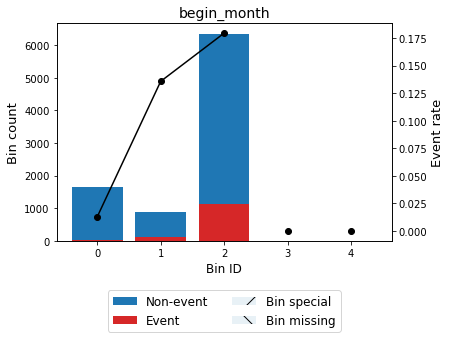

In [89]:
variable = 'begin_month'

x = train_df[variable].values
y = train_df.credit

optb = OptimalBinning(name = variable, dtype = "numerical", solver = "cp", max_n_prebins = 3)
optb.fit(x, y)
    
binning_table = optb.binning_table
v1 = binning_table.build()
    
display(v1)
binning_table.plot(metric = 'event_rate')

In [90]:
# train 데이터의 'begin_month' 변수에 대한 최적 구간을 사용하여 파생 변수를 만듭니다.
x_train_transform_bins = optb.transform(train_df['begin_month'], metric="bins")
train_df['begin_month_bin'] = x_train_transform_bins

# test 데이터의 'begin_month' 변수에 대해서도 train 데이터와 동일한 최적 구간을 사용하여 파생 변수를 만듭니다.
x_test_transform_bins = optb.transform(test_df['begin_month'], metric="bins")
test_df['begin_month_bin'] = x_test_transform_bins

- Categorical Data

In [91]:
from optbinning import OptimalBinning

iv_df = []

for i in categorical_list : 
    variable = i
    x = train_df[variable].values
    y = train_df.credit
    
    optb = OptimalBinning(name = variable, dtype = "categorical", solver = "cp")
    optb.fit(x, y)
    
    binning_table = optb.binning_table
    v1 = binning_table.build()
    
    loop_df = pd.DataFrame({'val' : variable, 'IV' : [v1.loc['Totals', 'IV']]})
    iv_df.append(loop_df)
    
iv_df = pd.concat(iv_df).reset_index(drop = True)
iv_df.sort_values(by = ['IV'], ascending = False)

,val,IV
8,UserCode,6.541434
7,occyp_type,0.011527
11,email,0.007895
6,house_type,0.006951
9,work_phone,0.006236
5,family_type,0.006087
2,reality,0.005893
12,family_size,0.005726
3,income_type,0.001231
4,edu_type,0.001102


In [92]:
# variable = 'UserCode'

# x = train_df[variable].values
# y = train_df.credit

# optb = OptimalBinning(name = variable, dtype = "categorical", solver = "cp")
# optb.fit(x, y)
    
# binning_table = optb.binning_table
# v1 = binning_table.build()
    
# display(v1)
# binning_table.plot(metric = 'event_rate')

In [93]:
# # train 데이터의 'begin_month' 변수에 대한 최적 구간을 사용하여 파생 변수를 만듭니다.
# x_train_transform_bins = optb.transform(train_df['UserCode'], metric="bins")
# train_df['UserCode_bin'] = x_train_transform_bins

# # test 데이터의 'begin_month' 변수에 대해서도 train 데이터와 동일한 최적 구간을 사용하여 파생 변수를 만듭니다.
# x_test_transform_bins = optb.transform(test_df['UserCode'], metric="bins")
# test_df['UserCode_bin'] = x_test_transform_bins

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Waiters/barmen staff, Not_retired, Low-skill ...",996,0.112352,872,124,0.124498,0.170282,0.003065,3.826264e-04
1,[Sales staff],855,0.096447,742,113,0.132164,0.101736,0.000963,1.202693e-04
2,"[Accountants, unemployed, Private service staff]",1174,0.132431,1015,159,0.135434,0.073514,0.000697,8.712390e-05
3,[Retired_Pensioner],759,0.085618,649,110,0.144928,-0.005274,0.000002,2.981923e-07
4,"[Laborers, Workers]",2722,0.307050,2326,396,0.145481,-0.009735,0.000029,3.649848e-06
5,[Managers],693,0.078173,591,102,0.147186,-0.023383,0.000043,5.387063e-06
6,"[Cooking staff, IT staff, High skill tech staff]",565,0.063734,479,86,0.152212,-0.062873,0.000258,3.219648e-05
7,"[Realty agents, Drivers]",530,0.059786,445,85,0.160377,-0.124803,0.000973,1.215646e-04
8,"[Medicine staff, Secretaries, Cleaning staff, ...",571,0.064411,467,104,0.182137,-0.278288,0.005497,6.849096e-04
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


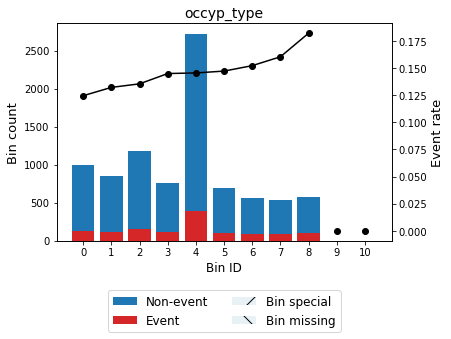

In [94]:
variable = 'occyp_type'

x = train_df[variable].values
y = train_df.credit

optb = OptimalBinning(name = variable, dtype = "categorical", solver = "cp")
optb.fit(x, y)
    
binning_table = optb.binning_table
v1 = binning_table.build()
    
display(v1)
binning_table.plot(metric = 'event_rate')

In [95]:
# train 데이터의 'begin_month' 변수에 대한 최적 구간을 사용하여 파생 변수를 만듭니다.
x_train_transform_bins = optb.transform(train_df['occyp_type'], metric="bins")
train_df['occyp_type_bin'] = x_train_transform_bins

# test 데이터의 'begin_month' 변수에 대해서도 train 데이터와 동일한 최적 구간을 사용하여 파생 변수를 만듭니다.
x_test_transform_bins = optb.transform(test_df['occyp_type'], metric="bins")
test_df['occyp_type_bin'] = x_test_transform_bins

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8865 entries, 0 to 8870
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          8865 non-null   int64  
 1   gender         8865 non-null   object 
 2   car            8865 non-null   object 
 3   reality        8865 non-null   object 
 4   child_num      8865 non-null   int64  
 5   income_total   8865 non-null   float64
 6   income_type    8865 non-null   object 
 7   edu_type       8865 non-null   object 
 8   family_type    8865 non-null   object 
 9   house_type     8865 non-null   object 
 10  DAYS_BIRTH     8865 non-null   int64  
 11  DAYS_EMPLOYED  8865 non-null   int64  
 12  FLAG_MOBIL     8865 non-null   int64  
 13  work_phone     8865 non-null   int64  
 14  phone          8865 non-null   int64  
 15  email          8865 non-null   int64  
 16  occyp_type     8865 non-null   object 
 17  family_size    8865 non-null   float64
 18  begin_month  

In [97]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2218 non-null   int64  
 1   gender         2218 non-null   object 
 2   car            2218 non-null   object 
 3   reality        2218 non-null   object 
 4   child_num      2218 non-null   int64  
 5   income_total   2218 non-null   float64
 6   income_type    2218 non-null   object 
 7   edu_type       2218 non-null   object 
 8   family_type    2218 non-null   object 
 9   house_type     2218 non-null   object 
 10  DAYS_BIRTH     2218 non-null   int64  
 11  DAYS_EMPLOYED  2218 non-null   int64  
 12  FLAG_MOBIL     2218 non-null   int64  
 13  work_phone     2218 non-null   int64  
 14  phone          2218 non-null   int64  
 15  email          2218 non-null   int64  
 16  occyp_type     2218 non-null   object 
 17  family_size    2218 non-null   float64
 18  begin_mo

### Scaling

1) Numerical column, Categorical column 나누기

In [98]:
# 1. dtype으로 나누기
numerical_list = []
categorical_list = []

for col, dtype in train_df.dtypes.items() : 
    if dtype == 'object' : 
        categorical_list.append(col)
    else :
        numerical_list.append(col)

In [99]:
# 2. 수기로 추가하기 (이미 숫자로 인코딩되어 표현된 경우)
add_categoric = ['work_phone', 'phone', 'email', 'family_size']

for i in add_categoric : 
    numerical_list.remove(i)
    
for i in add_categoric : 
    categorical_list.append(i)

In [100]:
print(numerical_list)
print(categorical_list)

['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'credit', 'age', 'before_EMPLOYED', 'income_total_befofeEMP_ratio', 'before_EMPLOYED_m', 'before_EMPLOYED_w', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'Age_group', 'EMPLOYED', 'DAYS_EMPLOYED_m', 'DAYS_EMPLOYED_w', 'ability', 'income_mean', 'income_pow', 'diff_fam_child', 'begin_month_y', 'begin_month_w', 'begin_month_d', 'cluster']
['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'UserCode', 'begin_month_bin', 'occyp_type_bin', 'work_phone', 'phone', 'email', 'family_size']


2) income_total, income_pow 컬럼은 로그변환 수행

In [101]:
train_df['income_total'] = np.log1p(1+train_df['income_total'])
test_df['income_total'] = np.log1p(1+test_df['income_total'])

train_df['income_pow'] = np.log1p(1+train_df['income_pow'])
test_df['income_pow'] = np.log1p(1+test_df['income_pow'])

3) Categorical data에 대해 Original Encoder 수행

In [102]:
encoder = OrdinalEncoder(categorical_list)
train_df[categorical_list] = encoder.fit_transform(train_df[categorical_list], train_df['credit'])
test_df[categorical_list] = encoder.transform(test_df[categorical_list])

In [103]:
train_df['UserCode'] = train_df['UserCode'].astype('int64')
test_df['UserCode'] = test_df['UserCode'].astype('int64')

4) Standard Scaler

In [104]:
numerical_list.remove('income_total')
numerical_list.remove('credit')

scaler = StandardScaler()
train_df[numerical_list] = scaler.fit_transform(train_df[numerical_list])
test_df[numerical_list] = scaler.transform(test_df[numerical_list])

### 다중공선성 분석

1) VIF 분석

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# numerical_list에 저장된 컬럼에 대해 데이터프레임 생성
numerical_df = train_df[numerical_list]

# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_df.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i) for i in range(len(numerical_df.columns))]

In [106]:
vif_data[vif_data["VIF"] >= 10]

,feature,VIF
1,DAYS_BIRTH,inf
2,DAYS_EMPLOYED,inf
3,begin_month,inf
4,age,1862.707454
5,before_EMPLOYED,inf
6,income_total_befofeEMP_ratio,11.103284
11,Age_group,18.392917
12,EMPLOYED,801.948777
15,ability,14.776650
19,begin_month_y,25.204323


In [107]:
columns_to_drop = ['begin_month_d', 'begin_month_w', 'begin_month_y', 'age', 'before_EMPLOYED',
                    'EMPLOYED', 'Age_group', 'income_total_befofeEMP_ratio']
for i in columns_to_drop : 
    numerical_list.remove(i)

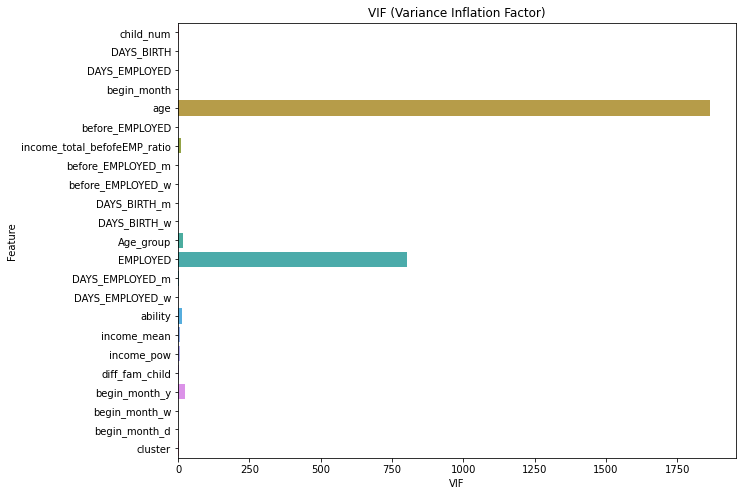

In [108]:
# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x="VIF", y="feature", data=vif_data)
plt.title("VIF (Variance Inflation Factor)")
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.show()

In [109]:
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

In [110]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8865 entries, 0 to 8870
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             8865 non-null   int32  
 1   car                8865 non-null   int32  
 2   reality            8865 non-null   int32  
 3   child_num          8865 non-null   float64
 4   income_total       8865 non-null   float64
 5   income_type        8865 non-null   int32  
 6   edu_type           8865 non-null   int32  
 7   family_type        8865 non-null   int32  
 8   house_type         8865 non-null   int32  
 9   DAYS_BIRTH         8865 non-null   float64
 10  DAYS_EMPLOYED      8865 non-null   float64
 11  work_phone         8865 non-null   int64  
 12  phone              8865 non-null   int64  
 13  email              8865 non-null   int64  
 14  occyp_type         8865 non-null   int32  
 15  family_size        8865 non-null   float64
 16  begin_month        8865 non-n

2) 상관관계 분석

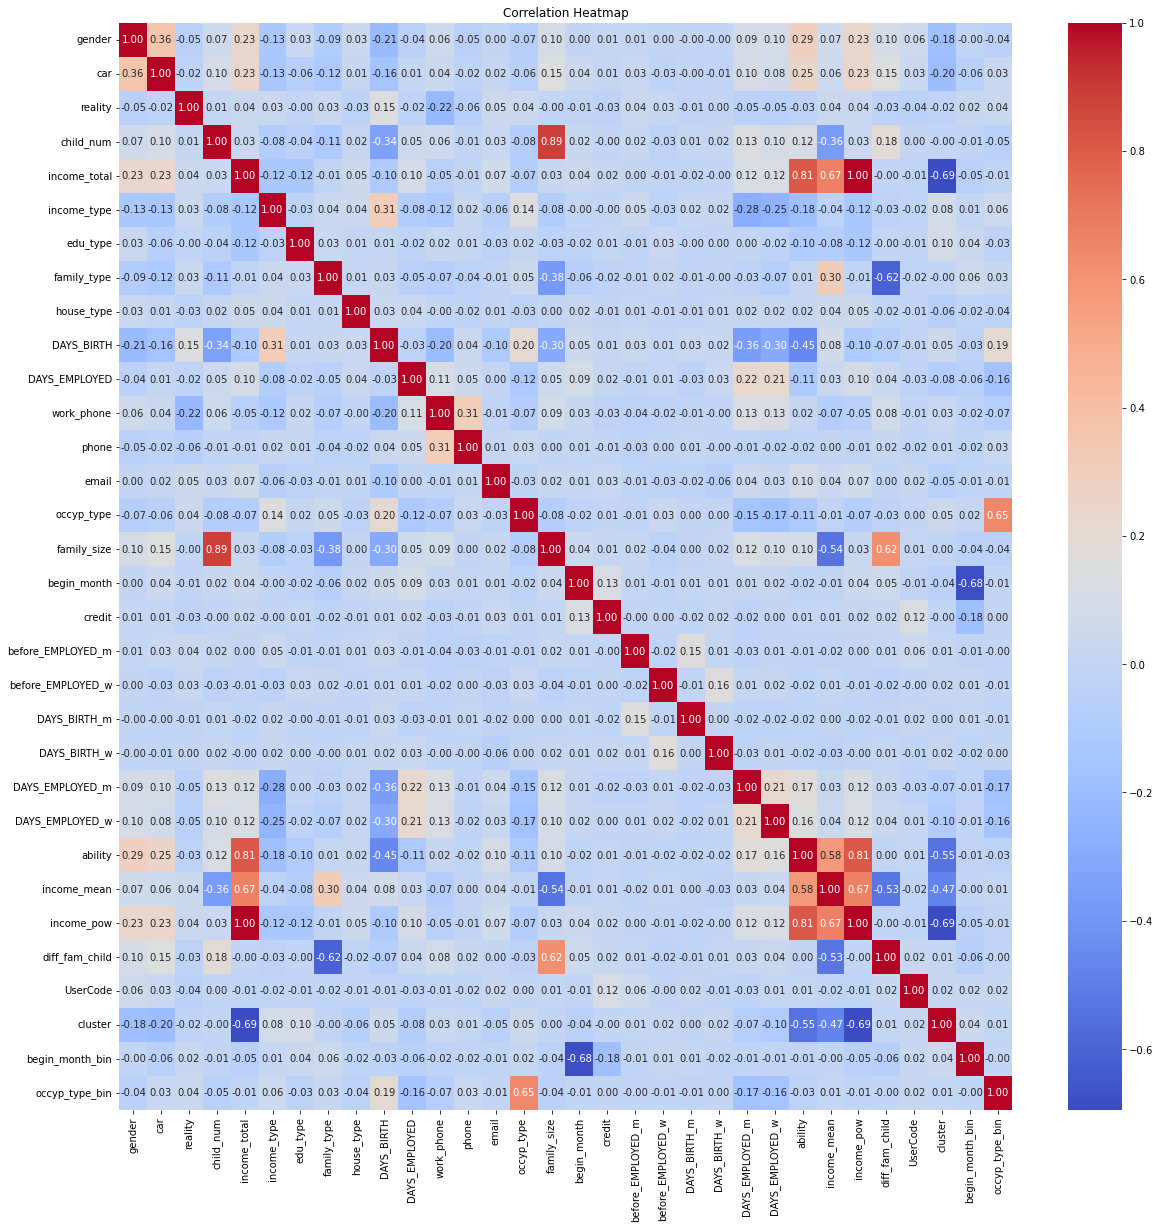

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임의 상관관계 구하기
correlation_matrix = train_df.corr()

# heatmap 시각화
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [112]:
# correlation_matrix에서 0.7 이상인 상관관계를 가진 컬럼 쌍 찾기
high_correlation_columns = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= 0.7:
            colname = correlation_matrix.columns[i]
            high_correlation_columns.add(colname)
            colname = correlation_matrix.columns[j]
            high_correlation_columns.add(colname)

# 상관관계가 0.7 이상인 컬럼들 출력
display("상관관계가 0.7 이상인 컬럼들:", high_correlation_columns)

'상관관계가 0.7 이상인 컬럼들:'

{'ability', 'child_num', 'family_size', 'income_pow', 'income_total'}

3) 컬럼 제거

In [113]:
columns_to_drop = ['ability', 'income_total', 'child_num']

In [114]:
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

### Modeling

1) 학습, 테스트 데이터셋 재정의

In [115]:
y_train = train_df['credit']
x_train = train_df.drop('credit', axis=1)
x_test = test_df.drop('credit', axis=1)
y_test = test_df['credit']

In [116]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8865 entries, 0 to 8870
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             8865 non-null   int32  
 1   car                8865 non-null   int32  
 2   reality            8865 non-null   int32  
 3   income_type        8865 non-null   int32  
 4   edu_type           8865 non-null   int32  
 5   family_type        8865 non-null   int32  
 6   house_type         8865 non-null   int32  
 7   DAYS_BIRTH         8865 non-null   float64
 8   DAYS_EMPLOYED      8865 non-null   float64
 9   work_phone         8865 non-null   int64  
 10  phone              8865 non-null   int64  
 11  email              8865 non-null   int64  
 12  occyp_type         8865 non-null   int32  
 13  family_size        8865 non-null   float64
 14  begin_month        8865 non-null   float64
 15  before_EMPLOYED_m  8865 non-null   float64
 16  before_EMPLOYED_w  8865 non-n

In [117]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2218 entries, 0 to 2217
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             2218 non-null   int32  
 1   car                2218 non-null   int32  
 2   reality            2218 non-null   int32  
 3   income_type        2218 non-null   int32  
 4   edu_type           2218 non-null   int32  
 5   family_type        2218 non-null   int32  
 6   house_type         2218 non-null   int32  
 7   DAYS_BIRTH         2218 non-null   float64
 8   DAYS_EMPLOYED      2218 non-null   float64
 9   work_phone         2218 non-null   int64  
 10  phone              2218 non-null   int64  
 11  email              2218 non-null   int64  
 12  occyp_type         2218 non-null   int32  
 13  family_size        2218 non-null   float64
 14  begin_month        2218 non-null   float64
 15  before_EMPLOYED_m  2218 non-null   float64
 16  before_EMPLOYED_w  2218 non-n

In [118]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

### GridSearchCV & CatBoost Classifier

In [119]:
n_est = 2000
seed = 42
n_fold = 5
n_class = 2

In [120]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
from catboost import Pool
import numpy as np
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items

# CatBoost 모델 객체 생성
model_cat = CatBoostClassifier()

param_grid = {
    'l2_leaf_reg': [1, 2],
    'iterations': [200],    
    'learning_rate': [0.1],
    'depth': [4, 5, 6],
    'random_strength': [1],
}

cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'UserCode']

# GridSearchCV 객체 생성
grid_search_cat = GridSearchCV(estimator=model_cat, param_grid=param_grid, cv=n_fold, scoring='neg_log_loss',refit = True, verbose = 100)

# 그리드서치를 사용하여 모델 학습
grid_search_cat.fit(x_train, y_train, cat_features=cat_cols)

# 최적 하이퍼파라미터 출력
print("Best Parameters:", grid_search_cat.best_params_)

# 최적 모델로 전체 데이터에 대한 예측 수행
pred_y_cat_proba = grid_search_cat.predict_proba(x_train)

# 전체 데이터에 대한 Log Loss 계산
train_log_loss = log_loss(y_train, pred_y_cat_proba)
print(f'Log Loss: {train_log_loss:.6f}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.1, random_strength=1
0:	learn: 0.6186587	total: 160ms	remaining: 31.8s
1:	learn: 0.5735363	total: 179ms	remaining: 17.7s
2:	learn: 0.5383082	total: 195ms	remaining: 12.8s
3:	learn: 0.5103692	total: 212ms	remaining: 10.4s
4:	learn: 0.4883369	total: 231ms	remaining: 9.02s
5:	learn: 0.4680421	total: 249ms	remaining: 8.05s
6:	learn: 0.4488297	total: 267ms	remaining: 7.37s
7:	learn: 0.4388076	total: 279ms	remaining: 6.71s
8:	learn: 0.4308754	total: 299ms	remaining: 6.34s
9:	learn: 0.4206067	total: 317ms	remaining: 6.03s
10:	learn: 0.4156751	total: 335ms	remaining: 5.75s
11:	learn: 0.4117961	total: 343ms	remaining: 5.38s
12:	learn: 0.4086001	total: 362ms	remaining: 5.21s
13:	learn: 0.4037793	total: 378ms	remaining: 5.02s
14:	learn: 0.3987252	total: 387ms	remaining: 4.77s
15:	learn: 0.3930167	total: 403ms	remaining: 4.63s
16:	learn: 0.3882469	total: 422ms	rem

160:	learn: 0.3309840	total: 3.04s	remaining: 736ms
161:	learn: 0.3308848	total: 3.05s	remaining: 717ms
162:	learn: 0.3306329	total: 3.07s	remaining: 698ms
163:	learn: 0.3302757	total: 3.09s	remaining: 679ms
164:	learn: 0.3301735	total: 3.11s	remaining: 660ms
165:	learn: 0.3300053	total: 3.13s	remaining: 641ms
166:	learn: 0.3298845	total: 3.14s	remaining: 621ms
167:	learn: 0.3296964	total: 3.16s	remaining: 602ms
168:	learn: 0.3294704	total: 3.18s	remaining: 583ms
169:	learn: 0.3293570	total: 3.2s	remaining: 564ms
170:	learn: 0.3291487	total: 3.22s	remaining: 546ms
171:	learn: 0.3288890	total: 3.23s	remaining: 527ms
172:	learn: 0.3287558	total: 3.25s	remaining: 508ms
173:	learn: 0.3284750	total: 3.27s	remaining: 489ms
174:	learn: 0.3280676	total: 3.29s	remaining: 470ms
175:	learn: 0.3280167	total: 3.31s	remaining: 451ms
176:	learn: 0.3276401	total: 3.33s	remaining: 432ms
177:	learn: 0.3275810	total: 3.34s	remaining: 413ms
178:	learn: 0.3275006	total: 3.36s	remaining: 395ms
179:	learn: 0

124:	learn: 0.3400893	total: 2.23s	remaining: 1.34s
125:	learn: 0.3397449	total: 2.25s	remaining: 1.32s
126:	learn: 0.3395512	total: 2.27s	remaining: 1.3s
127:	learn: 0.3393063	total: 2.29s	remaining: 1.29s
128:	learn: 0.3390508	total: 2.31s	remaining: 1.27s
129:	learn: 0.3388567	total: 2.33s	remaining: 1.25s
130:	learn: 0.3388072	total: 2.34s	remaining: 1.23s
131:	learn: 0.3383548	total: 2.36s	remaining: 1.22s
132:	learn: 0.3378730	total: 2.38s	remaining: 1.2s
133:	learn: 0.3377476	total: 2.4s	remaining: 1.18s
134:	learn: 0.3376464	total: 2.41s	remaining: 1.16s
135:	learn: 0.3373220	total: 2.43s	remaining: 1.14s
136:	learn: 0.3365202	total: 2.45s	remaining: 1.13s
137:	learn: 0.3364386	total: 2.47s	remaining: 1.11s
138:	learn: 0.3362529	total: 2.48s	remaining: 1.09s
139:	learn: 0.3358608	total: 2.5s	remaining: 1.07s
140:	learn: 0.3354715	total: 2.52s	remaining: 1.05s
141:	learn: 0.3351911	total: 2.54s	remaining: 1.04s
142:	learn: 0.3351011	total: 2.56s	remaining: 1.02s
143:	learn: 0.33

86:	learn: 0.3478571	total: 1.69s	remaining: 2.2s
87:	learn: 0.3474881	total: 1.71s	remaining: 2.18s
88:	learn: 0.3470651	total: 1.73s	remaining: 2.15s
89:	learn: 0.3469157	total: 1.75s	remaining: 2.14s
90:	learn: 0.3466370	total: 1.77s	remaining: 2.12s
91:	learn: 0.3462922	total: 1.79s	remaining: 2.1s
92:	learn: 0.3459896	total: 1.81s	remaining: 2.08s
93:	learn: 0.3459128	total: 1.84s	remaining: 2.08s
94:	learn: 0.3457849	total: 1.86s	remaining: 2.06s
95:	learn: 0.3455332	total: 1.89s	remaining: 2.04s
96:	learn: 0.3453741	total: 1.9s	remaining: 2.02s
97:	learn: 0.3450232	total: 1.92s	remaining: 2s
98:	learn: 0.3449968	total: 1.94s	remaining: 1.98s
99:	learn: 0.3446848	total: 1.96s	remaining: 1.96s
100:	learn: 0.3445045	total: 1.98s	remaining: 1.94s
101:	learn: 0.3443159	total: 2s	remaining: 1.92s
102:	learn: 0.3440890	total: 2.02s	remaining: 1.9s
103:	learn: 0.3434504	total: 2.03s	remaining: 1.88s
104:	learn: 0.3431961	total: 2.06s	remaining: 1.86s
105:	learn: 0.3431433	total: 2.08s	r

49:	learn: 0.3546449	total: 916ms	remaining: 2.75s
50:	learn: 0.3543286	total: 935ms	remaining: 2.73s
51:	learn: 0.3540496	total: 952ms	remaining: 2.71s
52:	learn: 0.3539209	total: 974ms	remaining: 2.7s
53:	learn: 0.3538057	total: 992ms	remaining: 2.68s
54:	learn: 0.3532912	total: 1.01s	remaining: 2.68s
55:	learn: 0.3531560	total: 1.04s	remaining: 2.67s
56:	learn: 0.3529140	total: 1.06s	remaining: 2.65s
57:	learn: 0.3527712	total: 1.07s	remaining: 2.63s
58:	learn: 0.3527448	total: 1.09s	remaining: 2.62s
59:	learn: 0.3525474	total: 1.11s	remaining: 2.6s
60:	learn: 0.3521976	total: 1.13s	remaining: 2.58s
61:	learn: 0.3520602	total: 1.16s	remaining: 2.57s
62:	learn: 0.3519753	total: 1.18s	remaining: 2.57s
63:	learn: 0.3517854	total: 1.21s	remaining: 2.57s
64:	learn: 0.3514868	total: 1.24s	remaining: 2.58s
65:	learn: 0.3511298	total: 1.26s	remaining: 2.57s
66:	learn: 0.3509142	total: 1.29s	remaining: 2.56s
67:	learn: 0.3505736	total: 1.31s	remaining: 2.54s
68:	learn: 0.3502772	total: 1.33s

11:	learn: 0.4133645	total: 211ms	remaining: 3.3s
12:	learn: 0.4034920	total: 221ms	remaining: 3.17s
13:	learn: 0.4011489	total: 240ms	remaining: 3.19s
14:	learn: 0.3942450	total: 259ms	remaining: 3.19s
15:	learn: 0.3901542	total: 272ms	remaining: 3.13s
16:	learn: 0.3855246	total: 287ms	remaining: 3.09s
17:	learn: 0.3817639	total: 305ms	remaining: 3.08s
18:	learn: 0.3779830	total: 322ms	remaining: 3.06s
19:	learn: 0.3748911	total: 339ms	remaining: 3.06s
20:	learn: 0.3731317	total: 358ms	remaining: 3.05s
21:	learn: 0.3716861	total: 371ms	remaining: 3s
22:	learn: 0.3704464	total: 389ms	remaining: 2.99s
23:	learn: 0.3689766	total: 402ms	remaining: 2.95s
24:	learn: 0.3664443	total: 420ms	remaining: 2.94s
25:	learn: 0.3652259	total: 435ms	remaining: 2.91s
26:	learn: 0.3643276	total: 453ms	remaining: 2.9s
27:	learn: 0.3631287	total: 471ms	remaining: 2.89s
28:	learn: 0.3625627	total: 491ms	remaining: 2.89s
29:	learn: 0.3622301	total: 506ms	remaining: 2.87s
30:	learn: 0.3615671	total: 525ms	re

176:	learn: 0.3260936	total: 3.44s	remaining: 446ms
177:	learn: 0.3259776	total: 3.45s	remaining: 427ms
178:	learn: 0.3257093	total: 3.47s	remaining: 407ms
179:	learn: 0.3253827	total: 3.48s	remaining: 387ms
180:	learn: 0.3252443	total: 3.5s	remaining: 368ms
181:	learn: 0.3251156	total: 3.52s	remaining: 349ms
182:	learn: 0.3250495	total: 3.54s	remaining: 329ms
183:	learn: 0.3248228	total: 3.56s	remaining: 309ms
184:	learn: 0.3247379	total: 3.58s	remaining: 290ms
185:	learn: 0.3245979	total: 3.6s	remaining: 271ms
186:	learn: 0.3243641	total: 3.62s	remaining: 252ms
187:	learn: 0.3242471	total: 3.64s	remaining: 232ms
188:	learn: 0.3241536	total: 3.66s	remaining: 213ms
189:	learn: 0.3240281	total: 3.68s	remaining: 194ms
190:	learn: 0.3239197	total: 3.7s	remaining: 174ms
191:	learn: 0.3237079	total: 3.72s	remaining: 155ms
192:	learn: 0.3234326	total: 3.74s	remaining: 136ms
193:	learn: 0.3232207	total: 3.76s	remaining: 116ms
194:	learn: 0.3230882	total: 3.78s	remaining: 96.9ms
195:	learn: 0.

135:	learn: 0.3370049	total: 2.7s	remaining: 1.27s
136:	learn: 0.3367233	total: 2.72s	remaining: 1.25s
137:	learn: 0.3366666	total: 2.74s	remaining: 1.23s
138:	learn: 0.3366106	total: 2.76s	remaining: 1.21s
139:	learn: 0.3364997	total: 2.79s	remaining: 1.19s
140:	learn: 0.3363496	total: 2.81s	remaining: 1.18s
141:	learn: 0.3362903	total: 2.83s	remaining: 1.16s
142:	learn: 0.3361587	total: 2.85s	remaining: 1.14s
143:	learn: 0.3360101	total: 2.87s	remaining: 1.12s
144:	learn: 0.3355814	total: 2.9s	remaining: 1.1s
145:	learn: 0.3354411	total: 2.92s	remaining: 1.08s
146:	learn: 0.3353566	total: 2.94s	remaining: 1.06s
147:	learn: 0.3350082	total: 2.96s	remaining: 1.04s
148:	learn: 0.3348597	total: 2.98s	remaining: 1.02s
149:	learn: 0.3348456	total: 3.01s	remaining: 1s
150:	learn: 0.3346394	total: 3.03s	remaining: 985ms
151:	learn: 0.3345602	total: 3.05s	remaining: 964ms
152:	learn: 0.3344510	total: 3.08s	remaining: 947ms
153:	learn: 0.3339511	total: 3.1s	remaining: 927ms
154:	learn: 0.33377

92:	learn: 0.3477429	total: 1.86s	remaining: 2.14s
93:	learn: 0.3477044	total: 1.88s	remaining: 2.12s
94:	learn: 0.3474955	total: 1.91s	remaining: 2.11s
95:	learn: 0.3471561	total: 1.93s	remaining: 2.09s
96:	learn: 0.3470461	total: 1.95s	remaining: 2.07s
97:	learn: 0.3470326	total: 1.96s	remaining: 2.04s
98:	learn: 0.3459635	total: 1.98s	remaining: 2.02s
99:	learn: 0.3458887	total: 2s	remaining: 2s
100:	learn: 0.3458556	total: 2.02s	remaining: 1.98s
101:	learn: 0.3456243	total: 2.04s	remaining: 1.96s
102:	learn: 0.3454855	total: 2.06s	remaining: 1.94s
103:	learn: 0.3454196	total: 2.08s	remaining: 1.92s
104:	learn: 0.3450744	total: 2.1s	remaining: 1.9s
105:	learn: 0.3450304	total: 2.12s	remaining: 1.88s
106:	learn: 0.3449162	total: 2.14s	remaining: 1.86s
107:	learn: 0.3447182	total: 2.16s	remaining: 1.84s
108:	learn: 0.3441582	total: 2.18s	remaining: 1.82s
109:	learn: 0.3439259	total: 2.2s	remaining: 1.8s
110:	learn: 0.3437244	total: 2.22s	remaining: 1.78s
111:	learn: 0.3436249	total: 2

51:	learn: 0.3569384	total: 957ms	remaining: 2.72s
52:	learn: 0.3565344	total: 977ms	remaining: 2.71s
53:	learn: 0.3562348	total: 994ms	remaining: 2.69s
54:	learn: 0.3561536	total: 1.01s	remaining: 2.67s
55:	learn: 0.3559195	total: 1.03s	remaining: 2.65s
56:	learn: 0.3557931	total: 1.05s	remaining: 2.64s
57:	learn: 0.3556436	total: 1.07s	remaining: 2.62s
58:	learn: 0.3556382	total: 1.09s	remaining: 2.6s
59:	learn: 0.3554597	total: 1.11s	remaining: 2.58s
60:	learn: 0.3552489	total: 1.12s	remaining: 2.56s
61:	learn: 0.3550055	total: 1.14s	remaining: 2.54s
62:	learn: 0.3546255	total: 1.16s	remaining: 2.52s
63:	learn: 0.3544914	total: 1.18s	remaining: 2.51s
64:	learn: 0.3542563	total: 1.2s	remaining: 2.48s
65:	learn: 0.3540407	total: 1.21s	remaining: 2.47s
66:	learn: 0.3538568	total: 1.23s	remaining: 2.45s
67:	learn: 0.3537002	total: 1.25s	remaining: 2.43s
68:	learn: 0.3535994	total: 1.27s	remaining: 2.41s
69:	learn: 0.3533145	total: 1.29s	remaining: 2.39s
70:	learn: 0.3529440	total: 1.31s

6:	learn: 0.4472830	total: 122ms	remaining: 3.36s
7:	learn: 0.4373787	total: 136ms	remaining: 3.26s
8:	learn: 0.4294913	total: 152ms	remaining: 3.22s
9:	learn: 0.4232159	total: 165ms	remaining: 3.14s
10:	learn: 0.4143602	total: 178ms	remaining: 3.05s
11:	learn: 0.4105284	total: 196ms	remaining: 3.06s
12:	learn: 0.4075260	total: 214ms	remaining: 3.08s
13:	learn: 0.4047744	total: 232ms	remaining: 3.08s
14:	learn: 0.3965672	total: 248ms	remaining: 3.06s
15:	learn: 0.3911990	total: 266ms	remaining: 3.06s
16:	learn: 0.3874025	total: 275ms	remaining: 2.96s
17:	learn: 0.3842934	total: 292ms	remaining: 2.95s
18:	learn: 0.3807577	total: 310ms	remaining: 2.95s
19:	learn: 0.3789219	total: 328ms	remaining: 2.95s
20:	learn: 0.3742528	total: 345ms	remaining: 2.94s
21:	learn: 0.3727768	total: 356ms	remaining: 2.88s
22:	learn: 0.3714376	total: 366ms	remaining: 2.82s
23:	learn: 0.3706241	total: 379ms	remaining: 2.78s
24:	learn: 0.3694656	total: 398ms	remaining: 2.79s
25:	learn: 0.3680713	total: 417ms	r

175:	learn: 0.3312616	total: 3.26s	remaining: 444ms
176:	learn: 0.3310840	total: 3.27s	remaining: 425ms
177:	learn: 0.3306803	total: 3.29s	remaining: 407ms
178:	learn: 0.3303015	total: 3.31s	remaining: 388ms
179:	learn: 0.3302321	total: 3.33s	remaining: 370ms
180:	learn: 0.3298210	total: 3.35s	remaining: 352ms
181:	learn: 0.3296669	total: 3.37s	remaining: 333ms
182:	learn: 0.3295744	total: 3.39s	remaining: 315ms
183:	learn: 0.3291792	total: 3.4s	remaining: 296ms
184:	learn: 0.3285280	total: 3.42s	remaining: 277ms
185:	learn: 0.3282294	total: 3.44s	remaining: 259ms
186:	learn: 0.3281688	total: 3.46s	remaining: 241ms
187:	learn: 0.3280763	total: 3.48s	remaining: 222ms
188:	learn: 0.3279363	total: 3.5s	remaining: 204ms
189:	learn: 0.3276761	total: 3.52s	remaining: 185ms
190:	learn: 0.3273682	total: 3.54s	remaining: 167ms
191:	learn: 0.3271850	total: 3.56s	remaining: 148ms
192:	learn: 0.3270877	total: 3.58s	remaining: 130ms
193:	learn: 0.3269966	total: 3.6s	remaining: 111ms
194:	learn: 0.3

137:	learn: 0.3393219	total: 3.11s	remaining: 1.4s
138:	learn: 0.3391680	total: 3.13s	remaining: 1.38s
139:	learn: 0.3389829	total: 3.16s	remaining: 1.35s
140:	learn: 0.3386557	total: 3.18s	remaining: 1.33s
141:	learn: 0.3383254	total: 3.2s	remaining: 1.31s
142:	learn: 0.3382057	total: 3.22s	remaining: 1.28s
143:	learn: 0.3378860	total: 3.24s	remaining: 1.26s
144:	learn: 0.3377179	total: 3.27s	remaining: 1.24s
145:	learn: 0.3374359	total: 3.29s	remaining: 1.22s
146:	learn: 0.3373265	total: 3.31s	remaining: 1.19s
147:	learn: 0.3371575	total: 3.33s	remaining: 1.17s
148:	learn: 0.3369394	total: 3.35s	remaining: 1.15s
149:	learn: 0.3367093	total: 3.37s	remaining: 1.12s
150:	learn: 0.3360913	total: 3.4s	remaining: 1.1s
151:	learn: 0.3359445	total: 3.42s	remaining: 1.08s
152:	learn: 0.3358677	total: 3.44s	remaining: 1.06s
153:	learn: 0.3354802	total: 3.47s	remaining: 1.03s
154:	learn: 0.3353250	total: 3.49s	remaining: 1.01s
155:	learn: 0.3351953	total: 3.51s	remaining: 990ms
156:	learn: 0.33

96:	learn: 0.3332174	total: 2.23s	remaining: 2.37s
97:	learn: 0.3325745	total: 2.26s	remaining: 2.35s
98:	learn: 0.3323005	total: 2.28s	remaining: 2.33s
99:	learn: 0.3320411	total: 2.31s	remaining: 2.31s
100:	learn: 0.3317546	total: 2.33s	remaining: 2.28s
101:	learn: 0.3314367	total: 2.36s	remaining: 2.26s
102:	learn: 0.3311413	total: 2.38s	remaining: 2.24s
103:	learn: 0.3307906	total: 2.4s	remaining: 2.22s
104:	learn: 0.3306225	total: 2.42s	remaining: 2.19s
105:	learn: 0.3305034	total: 2.45s	remaining: 2.17s
106:	learn: 0.3302122	total: 2.47s	remaining: 2.15s
107:	learn: 0.3296530	total: 2.5s	remaining: 2.13s
108:	learn: 0.3294887	total: 2.52s	remaining: 2.1s
109:	learn: 0.3290600	total: 2.54s	remaining: 2.08s
110:	learn: 0.3288492	total: 2.57s	remaining: 2.06s
111:	learn: 0.3286003	total: 2.59s	remaining: 2.04s
112:	learn: 0.3284388	total: 2.62s	remaining: 2.02s
113:	learn: 0.3283537	total: 2.65s	remaining: 2s
114:	learn: 0.3281008	total: 2.67s	remaining: 1.98s
115:	learn: 0.3276582	

58:	learn: 0.3487455	total: 1.31s	remaining: 3.13s
59:	learn: 0.3485185	total: 1.33s	remaining: 3.1s
60:	learn: 0.3480978	total: 1.35s	remaining: 3.08s
61:	learn: 0.3475020	total: 1.37s	remaining: 3.06s
62:	learn: 0.3469987	total: 1.4s	remaining: 3.04s
63:	learn: 0.3467377	total: 1.42s	remaining: 3.02s
64:	learn: 0.3464812	total: 1.45s	remaining: 3.01s
65:	learn: 0.3462272	total: 1.47s	remaining: 2.99s
66:	learn: 0.3457656	total: 1.49s	remaining: 2.97s
67:	learn: 0.3457461	total: 1.51s	remaining: 2.94s
68:	learn: 0.3443676	total: 1.54s	remaining: 2.92s
69:	learn: 0.3437259	total: 1.56s	remaining: 2.89s
70:	learn: 0.3435953	total: 1.58s	remaining: 2.87s
71:	learn: 0.3433536	total: 1.6s	remaining: 2.85s
72:	learn: 0.3433102	total: 1.63s	remaining: 2.83s
73:	learn: 0.3428024	total: 1.65s	remaining: 2.81s
74:	learn: 0.3426235	total: 1.67s	remaining: 2.79s
75:	learn: 0.3423282	total: 1.7s	remaining: 2.77s
76:	learn: 0.3419686	total: 1.72s	remaining: 2.75s
77:	learn: 0.3415161	total: 1.74s	r

14:	learn: 0.3889330	total: 312ms	remaining: 3.85s
15:	learn: 0.3850696	total: 333ms	remaining: 3.83s
16:	learn: 0.3821006	total: 352ms	remaining: 3.79s
17:	learn: 0.3789309	total: 371ms	remaining: 3.75s
18:	learn: 0.3759472	total: 390ms	remaining: 3.72s
19:	learn: 0.3736536	total: 413ms	remaining: 3.72s
20:	learn: 0.3717972	total: 432ms	remaining: 3.68s
21:	learn: 0.3699534	total: 452ms	remaining: 3.65s
22:	learn: 0.3687358	total: 471ms	remaining: 3.63s
23:	learn: 0.3669624	total: 491ms	remaining: 3.6s
24:	learn: 0.3658885	total: 509ms	remaining: 3.56s
25:	learn: 0.3648772	total: 524ms	remaining: 3.5s
26:	learn: 0.3639705	total: 542ms	remaining: 3.47s
27:	learn: 0.3619137	total: 560ms	remaining: 3.44s
28:	learn: 0.3611570	total: 578ms	remaining: 3.41s
29:	learn: 0.3603125	total: 595ms	remaining: 3.37s
30:	learn: 0.3596761	total: 611ms	remaining: 3.33s
31:	learn: 0.3592832	total: 631ms	remaining: 3.31s
32:	learn: 0.3585927	total: 656ms	remaining: 3.32s
33:	learn: 0.3582803	total: 666ms

180:	learn: 0.3065616	total: 3.88s	remaining: 408ms
181:	learn: 0.3063858	total: 3.91s	remaining: 387ms
182:	learn: 0.3060789	total: 3.93s	remaining: 366ms
183:	learn: 0.3059795	total: 3.96s	remaining: 344ms
184:	learn: 0.3055481	total: 3.98s	remaining: 323ms
185:	learn: 0.3052045	total: 4s	remaining: 301ms
186:	learn: 0.3048039	total: 4.02s	remaining: 279ms
187:	learn: 0.3046470	total: 4.04s	remaining: 258ms
188:	learn: 0.3044559	total: 4.06s	remaining: 236ms
189:	learn: 0.3037114	total: 4.08s	remaining: 215ms
190:	learn: 0.3036603	total: 4.11s	remaining: 193ms
191:	learn: 0.3033592	total: 4.13s	remaining: 172ms
192:	learn: 0.3029301	total: 4.16s	remaining: 151ms
193:	learn: 0.3026417	total: 4.18s	remaining: 129ms
194:	learn: 0.3022624	total: 4.2s	remaining: 108ms
195:	learn: 0.3020021	total: 4.22s	remaining: 86.2ms
196:	learn: 0.3017420	total: 4.24s	remaining: 64.6ms
197:	learn: 0.3016647	total: 4.28s	remaining: 43.2ms
198:	learn: 0.3014434	total: 4.3s	remaining: 21.6ms
199:	learn: 0

140:	learn: 0.3198823	total: 2.69s	remaining: 1.13s
141:	learn: 0.3194397	total: 2.71s	remaining: 1.11s
142:	learn: 0.3186595	total: 2.73s	remaining: 1.09s
143:	learn: 0.3185761	total: 2.75s	remaining: 1.07s
144:	learn: 0.3181806	total: 2.77s	remaining: 1.05s
145:	learn: 0.3177592	total: 2.79s	remaining: 1.03s
146:	learn: 0.3175992	total: 2.81s	remaining: 1.01s
147:	learn: 0.3172667	total: 2.84s	remaining: 998ms
148:	learn: 0.3170207	total: 2.86s	remaining: 979ms
149:	learn: 0.3167069	total: 2.88s	remaining: 960ms
150:	learn: 0.3162649	total: 2.9s	remaining: 941ms
151:	learn: 0.3157053	total: 2.92s	remaining: 923ms
152:	learn: 0.3154114	total: 2.94s	remaining: 904ms
153:	learn: 0.3147159	total: 2.96s	remaining: 886ms
154:	learn: 0.3146361	total: 2.98s	remaining: 867ms
155:	learn: 0.3141869	total: 3s	remaining: 848ms
156:	learn: 0.3140038	total: 3.02s	remaining: 829ms
157:	learn: 0.3138312	total: 3.04s	remaining: 809ms
158:	learn: 0.3133775	total: 3.06s	remaining: 790ms
159:	learn: 0.31

96:	learn: 0.3372861	total: 1.72s	remaining: 1.83s
97:	learn: 0.3368875	total: 1.74s	remaining: 1.81s
98:	learn: 0.3365612	total: 1.75s	remaining: 1.79s
99:	learn: 0.3364970	total: 1.77s	remaining: 1.77s
100:	learn: 0.3360819	total: 1.79s	remaining: 1.76s
101:	learn: 0.3359300	total: 1.81s	remaining: 1.74s
102:	learn: 0.3356679	total: 1.83s	remaining: 1.72s
103:	learn: 0.3352004	total: 1.85s	remaining: 1.71s
104:	learn: 0.3347844	total: 1.87s	remaining: 1.69s
105:	learn: 0.3344658	total: 1.89s	remaining: 1.67s
106:	learn: 0.3342884	total: 1.9s	remaining: 1.66s
107:	learn: 0.3332156	total: 1.92s	remaining: 1.64s
108:	learn: 0.3326377	total: 1.94s	remaining: 1.62s
109:	learn: 0.3318323	total: 1.96s	remaining: 1.6s
110:	learn: 0.3317184	total: 1.98s	remaining: 1.59s
111:	learn: 0.3315839	total: 2s	remaining: 1.57s
112:	learn: 0.3312963	total: 2.02s	remaining: 1.56s
113:	learn: 0.3309215	total: 2.04s	remaining: 1.54s
114:	learn: 0.3305163	total: 2.07s	remaining: 1.53s
115:	learn: 0.3298582

60:	learn: 0.3492557	total: 1.1s	remaining: 2.5s
61:	learn: 0.3489930	total: 1.12s	remaining: 2.48s
62:	learn: 0.3486982	total: 1.13s	remaining: 2.47s
63:	learn: 0.3482675	total: 1.15s	remaining: 2.45s
64:	learn: 0.3477736	total: 1.17s	remaining: 2.43s
65:	learn: 0.3473788	total: 1.19s	remaining: 2.42s
66:	learn: 0.3468743	total: 1.21s	remaining: 2.4s
67:	learn: 0.3468156	total: 1.23s	remaining: 2.38s
68:	learn: 0.3461132	total: 1.25s	remaining: 2.36s
69:	learn: 0.3456530	total: 1.26s	remaining: 2.35s
70:	learn: 0.3454917	total: 1.28s	remaining: 2.33s
71:	learn: 0.3452981	total: 1.3s	remaining: 2.31s
72:	learn: 0.3448597	total: 1.32s	remaining: 2.3s
73:	learn: 0.3444853	total: 1.34s	remaining: 2.28s
74:	learn: 0.3441136	total: 1.36s	remaining: 2.27s
75:	learn: 0.3439258	total: 1.38s	remaining: 2.25s
76:	learn: 0.3438448	total: 1.4s	remaining: 2.23s
77:	learn: 0.3437154	total: 1.42s	remaining: 2.22s
78:	learn: 0.3433908	total: 1.44s	remaining: 2.2s
79:	learn: 0.3426788	total: 1.46s	rema

18:	learn: 0.3796322	total: 258ms	remaining: 2.46s
19:	learn: 0.3768201	total: 278ms	remaining: 2.5s
20:	learn: 0.3752377	total: 286ms	remaining: 2.43s
21:	learn: 0.3733350	total: 307ms	remaining: 2.48s
22:	learn: 0.3717618	total: 323ms	remaining: 2.49s
23:	learn: 0.3697714	total: 339ms	remaining: 2.49s
24:	learn: 0.3690795	total: 356ms	remaining: 2.49s
25:	learn: 0.3658769	total: 372ms	remaining: 2.49s
26:	learn: 0.3652490	total: 379ms	remaining: 2.43s
27:	learn: 0.3627743	total: 395ms	remaining: 2.42s
28:	learn: 0.3616966	total: 412ms	remaining: 2.43s
29:	learn: 0.3606103	total: 440ms	remaining: 2.49s
30:	learn: 0.3597363	total: 456ms	remaining: 2.49s
31:	learn: 0.3593177	total: 473ms	remaining: 2.48s
32:	learn: 0.3586199	total: 489ms	remaining: 2.47s
33:	learn: 0.3578229	total: 505ms	remaining: 2.46s
34:	learn: 0.3572912	total: 524ms	remaining: 2.47s
35:	learn: 0.3571862	total: 532ms	remaining: 2.42s
36:	learn: 0.3566501	total: 548ms	remaining: 2.41s
37:	learn: 0.3560606	total: 565m

187:	learn: 0.3100361	total: 3.25s	remaining: 208ms
188:	learn: 0.3098356	total: 3.28s	remaining: 191ms
189:	learn: 0.3095462	total: 3.3s	remaining: 174ms
190:	learn: 0.3089867	total: 3.32s	remaining: 156ms
191:	learn: 0.3089089	total: 3.34s	remaining: 139ms
192:	learn: 0.3088260	total: 3.36s	remaining: 122ms
193:	learn: 0.3086476	total: 3.38s	remaining: 104ms
194:	learn: 0.3082047	total: 3.4s	remaining: 87.1ms
195:	learn: 0.3079474	total: 3.42s	remaining: 69.8ms
196:	learn: 0.3077673	total: 3.44s	remaining: 52.4ms
197:	learn: 0.3073714	total: 3.46s	remaining: 35ms
198:	learn: 0.3070651	total: 3.49s	remaining: 17.5ms
199:	learn: 0.3069522	total: 3.51s	remaining: 0us
[CV 2/5; 4/6] END depth=5, iterations=200, l2_leaf_reg=2, learning_rate=0.1, random_strength=1;, score=-0.369 total time=   3.5s
[CV 3/5; 4/6] START depth=5, iterations=200, l2_leaf_reg=2, learning_rate=0.1, random_strength=1
0:	learn: 0.6200501	total: 31.5ms	remaining: 6.26s
1:	learn: 0.5745907	total: 49.7ms	remaining: 4.9

151:	learn: 0.3202376	total: 2.86s	remaining: 903ms
152:	learn: 0.3193061	total: 2.88s	remaining: 884ms
153:	learn: 0.3191088	total: 2.89s	remaining: 864ms
154:	learn: 0.3189972	total: 2.91s	remaining: 845ms
155:	learn: 0.3187962	total: 2.93s	remaining: 826ms
156:	learn: 0.3185233	total: 2.94s	remaining: 806ms
157:	learn: 0.3181902	total: 2.96s	remaining: 787ms
158:	learn: 0.3180506	total: 2.98s	remaining: 768ms
159:	learn: 0.3179027	total: 2.99s	remaining: 749ms
160:	learn: 0.3177179	total: 3.01s	remaining: 729ms
161:	learn: 0.3176954	total: 3.03s	remaining: 710ms
162:	learn: 0.3172271	total: 3.05s	remaining: 692ms
163:	learn: 0.3170067	total: 3.06s	remaining: 673ms
164:	learn: 0.3169036	total: 3.08s	remaining: 654ms
165:	learn: 0.3163818	total: 3.1s	remaining: 635ms
166:	learn: 0.3161555	total: 3.12s	remaining: 616ms
167:	learn: 0.3160637	total: 3.14s	remaining: 598ms
168:	learn: 0.3159782	total: 3.15s	remaining: 579ms
169:	learn: 0.3154035	total: 3.18s	remaining: 561ms
170:	learn: 0

109:	learn: 0.3348465	total: 2.02s	remaining: 1.65s
110:	learn: 0.3347158	total: 2.04s	remaining: 1.63s
111:	learn: 0.3341039	total: 2.06s	remaining: 1.61s
112:	learn: 0.3337957	total: 2.07s	remaining: 1.59s
113:	learn: 0.3334583	total: 2.09s	remaining: 1.58s
114:	learn: 0.3333306	total: 2.11s	remaining: 1.56s
115:	learn: 0.3332793	total: 2.13s	remaining: 1.54s
116:	learn: 0.3330273	total: 2.14s	remaining: 1.52s
117:	learn: 0.3329856	total: 2.16s	remaining: 1.5s
118:	learn: 0.3327459	total: 2.18s	remaining: 1.48s
119:	learn: 0.3322183	total: 2.2s	remaining: 1.46s
120:	learn: 0.3322046	total: 2.21s	remaining: 1.45s
121:	learn: 0.3316553	total: 2.23s	remaining: 1.43s
122:	learn: 0.3311454	total: 2.25s	remaining: 1.41s
123:	learn: 0.3306725	total: 2.27s	remaining: 1.39s
124:	learn: 0.3300165	total: 2.29s	remaining: 1.37s
125:	learn: 0.3297559	total: 2.3s	remaining: 1.35s
126:	learn: 0.3295694	total: 2.32s	remaining: 1.33s
127:	learn: 0.3295524	total: 2.34s	remaining: 1.31s
128:	learn: 0.3

68:	learn: 0.3459146	total: 1.21s	remaining: 2.29s
69:	learn: 0.3454950	total: 1.24s	remaining: 2.3s
70:	learn: 0.3454266	total: 1.26s	remaining: 2.28s
71:	learn: 0.3449382	total: 1.27s	remaining: 2.27s
72:	learn: 0.3448912	total: 1.29s	remaining: 2.25s
73:	learn: 0.3445816	total: 1.31s	remaining: 2.24s
74:	learn: 0.3440799	total: 1.33s	remaining: 2.22s
75:	learn: 0.3439178	total: 1.35s	remaining: 2.21s
76:	learn: 0.3437309	total: 1.37s	remaining: 2.19s
77:	learn: 0.3432965	total: 1.39s	remaining: 2.17s
78:	learn: 0.3428644	total: 1.41s	remaining: 2.16s
79:	learn: 0.3427127	total: 1.43s	remaining: 2.14s
80:	learn: 0.3420589	total: 1.45s	remaining: 2.12s
81:	learn: 0.3417706	total: 1.46s	remaining: 2.1s
82:	learn: 0.3414300	total: 1.48s	remaining: 2.09s
83:	learn: 0.3413569	total: 1.5s	remaining: 2.07s
84:	learn: 0.3411278	total: 1.52s	remaining: 2.05s
85:	learn: 0.3407940	total: 1.53s	remaining: 2.03s
86:	learn: 0.3404763	total: 1.55s	remaining: 2.02s
87:	learn: 0.3402760	total: 1.57s	

31:	learn: 0.3528189	total: 681ms	remaining: 3.58s
32:	learn: 0.3518063	total: 703ms	remaining: 3.56s
33:	learn: 0.3514705	total: 724ms	remaining: 3.54s
34:	learn: 0.3507372	total: 746ms	remaining: 3.52s
35:	learn: 0.3507158	total: 754ms	remaining: 3.43s
36:	learn: 0.3500460	total: 775ms	remaining: 3.41s
37:	learn: 0.3494690	total: 796ms	remaining: 3.39s
38:	learn: 0.3489650	total: 821ms	remaining: 3.39s
39:	learn: 0.3481530	total: 844ms	remaining: 3.38s
40:	learn: 0.3477218	total: 868ms	remaining: 3.37s
41:	learn: 0.3469021	total: 890ms	remaining: 3.35s
42:	learn: 0.3457003	total: 912ms	remaining: 3.33s
43:	learn: 0.3453968	total: 950ms	remaining: 3.37s
44:	learn: 0.3450728	total: 973ms	remaining: 3.35s
45:	learn: 0.3445158	total: 997ms	remaining: 3.34s
46:	learn: 0.3442016	total: 1.02s	remaining: 3.32s
47:	learn: 0.3439780	total: 1.04s	remaining: 3.31s
48:	learn: 0.3434949	total: 1.07s	remaining: 3.29s
49:	learn: 0.3431450	total: 1.09s	remaining: 3.28s
50:	learn: 0.3425489	total: 1.1

195:	learn: 0.2756032	total: 4.62s	remaining: 94.3ms
196:	learn: 0.2753061	total: 4.65s	remaining: 70.8ms
197:	learn: 0.2748114	total: 4.67s	remaining: 47.1ms
198:	learn: 0.2740891	total: 4.69s	remaining: 23.6ms
199:	learn: 0.2737881	total: 4.71s	remaining: 0us
[CV 1/5; 5/6] END depth=6, iterations=200, l2_leaf_reg=1, learning_rate=0.1, random_strength=1;, score=-0.376 total time=   4.7s
[CV 2/5; 5/6] START depth=6, iterations=200, l2_leaf_reg=1, learning_rate=0.1, random_strength=1
0:	learn: 0.6180802	total: 16.1ms	remaining: 3.21s
1:	learn: 0.5726138	total: 38ms	remaining: 3.76s
2:	learn: 0.5370109	total: 61.5ms	remaining: 4.04s
3:	learn: 0.5000630	total: 86.1ms	remaining: 4.22s
4:	learn: 0.4794035	total: 91.8ms	remaining: 3.58s
5:	learn: 0.4628261	total: 115ms	remaining: 3.73s
6:	learn: 0.4498240	total: 138ms	remaining: 3.81s
7:	learn: 0.4386228	total: 161ms	remaining: 3.86s
8:	learn: 0.4296248	total: 182ms	remaining: 3.86s
9:	learn: 0.4209542	total: 212ms	remaining: 4.02s
10:	learn

154:	learn: 0.2929363	total: 3.66s	remaining: 1.06s
155:	learn: 0.2918894	total: 3.68s	remaining: 1.04s
156:	learn: 0.2915946	total: 3.7s	remaining: 1.01s
157:	learn: 0.2907549	total: 3.73s	remaining: 991ms
158:	learn: 0.2900954	total: 3.75s	remaining: 967ms
159:	learn: 0.2899132	total: 3.77s	remaining: 943ms
160:	learn: 0.2893302	total: 3.79s	remaining: 919ms
161:	learn: 0.2888614	total: 3.81s	remaining: 895ms
162:	learn: 0.2883558	total: 3.84s	remaining: 871ms
163:	learn: 0.2875115	total: 3.86s	remaining: 847ms
164:	learn: 0.2870835	total: 3.88s	remaining: 823ms
165:	learn: 0.2868285	total: 3.9s	remaining: 799ms
166:	learn: 0.2862084	total: 3.93s	remaining: 776ms
167:	learn: 0.2857825	total: 3.95s	remaining: 753ms
168:	learn: 0.2854090	total: 3.98s	remaining: 729ms
169:	learn: 0.2849958	total: 4s	remaining: 706ms
170:	learn: 0.2844158	total: 4.03s	remaining: 683ms
171:	learn: 0.2840538	total: 4.05s	remaining: 660ms
172:	learn: 0.2835968	total: 4.09s	remaining: 638ms
173:	learn: 0.282

112:	learn: 0.3159938	total: 2.33s	remaining: 1.79s
113:	learn: 0.3152077	total: 2.35s	remaining: 1.77s
114:	learn: 0.3145424	total: 2.37s	remaining: 1.75s
115:	learn: 0.3141868	total: 2.39s	remaining: 1.73s
116:	learn: 0.3134932	total: 2.41s	remaining: 1.71s
117:	learn: 0.3127586	total: 2.43s	remaining: 1.69s
118:	learn: 0.3121989	total: 2.45s	remaining: 1.67s
119:	learn: 0.3112234	total: 2.48s	remaining: 1.65s
120:	learn: 0.3105321	total: 2.5s	remaining: 1.63s
121:	learn: 0.3101949	total: 2.52s	remaining: 1.61s
122:	learn: 0.3098829	total: 2.54s	remaining: 1.59s
123:	learn: 0.3088523	total: 2.56s	remaining: 1.57s
124:	learn: 0.3081924	total: 2.58s	remaining: 1.55s
125:	learn: 0.3078025	total: 2.6s	remaining: 1.53s
126:	learn: 0.3073849	total: 2.62s	remaining: 1.51s
127:	learn: 0.3067590	total: 2.64s	remaining: 1.49s
128:	learn: 0.3056611	total: 2.66s	remaining: 1.47s
129:	learn: 0.3049844	total: 2.68s	remaining: 1.45s
130:	learn: 0.3039345	total: 2.7s	remaining: 1.42s
131:	learn: 0.3

70:	learn: 0.3344198	total: 1.61s	remaining: 2.92s
71:	learn: 0.3340765	total: 1.64s	remaining: 2.91s
72:	learn: 0.3338290	total: 1.66s	remaining: 2.89s
73:	learn: 0.3332647	total: 1.69s	remaining: 2.87s
74:	learn: 0.3326552	total: 1.71s	remaining: 2.85s
75:	learn: 0.3326496	total: 1.73s	remaining: 2.82s
76:	learn: 0.3317069	total: 1.76s	remaining: 2.81s
77:	learn: 0.3313176	total: 1.79s	remaining: 2.79s
78:	learn: 0.3310715	total: 1.81s	remaining: 2.78s
79:	learn: 0.3305729	total: 1.83s	remaining: 2.75s
80:	learn: 0.3302366	total: 1.86s	remaining: 2.73s
81:	learn: 0.3296719	total: 1.88s	remaining: 2.7s
82:	learn: 0.3294418	total: 1.9s	remaining: 2.68s
83:	learn: 0.3290758	total: 1.92s	remaining: 2.65s
84:	learn: 0.3281670	total: 1.94s	remaining: 2.63s
85:	learn: 0.3276329	total: 1.97s	remaining: 2.6s
86:	learn: 0.3265790	total: 1.99s	remaining: 2.58s
87:	learn: 0.3257130	total: 2.01s	remaining: 2.56s
88:	learn: 0.3253873	total: 2.03s	remaining: 2.53s
89:	learn: 0.3251729	total: 2.05s	

32:	learn: 0.3546777	total: 610ms	remaining: 3.09s
33:	learn: 0.3540725	total: 630ms	remaining: 3.08s
34:	learn: 0.3536421	total: 650ms	remaining: 3.06s
35:	learn: 0.3526693	total: 671ms	remaining: 3.05s
36:	learn: 0.3518878	total: 690ms	remaining: 3.04s
37:	learn: 0.3508303	total: 710ms	remaining: 3.03s
38:	learn: 0.3499657	total: 730ms	remaining: 3.01s
39:	learn: 0.3490775	total: 751ms	remaining: 3s
40:	learn: 0.3483232	total: 772ms	remaining: 2.99s
41:	learn: 0.3478548	total: 793ms	remaining: 2.98s
42:	learn: 0.3467937	total: 814ms	remaining: 2.97s
43:	learn: 0.3464189	total: 832ms	remaining: 2.95s
44:	learn: 0.3463306	total: 848ms	remaining: 2.92s
45:	learn: 0.3460428	total: 868ms	remaining: 2.9s
46:	learn: 0.3458727	total: 888ms	remaining: 2.89s
47:	learn: 0.3447856	total: 910ms	remaining: 2.88s
48:	learn: 0.3444363	total: 931ms	remaining: 2.87s
49:	learn: 0.3439304	total: 955ms	remaining: 2.86s
50:	learn: 0.3433384	total: 977ms	remaining: 2.85s
51:	learn: 0.3426876	total: 997ms	r

197:	learn: 0.2744996	total: 4.42s	remaining: 44.7ms
198:	learn: 0.2741395	total: 4.45s	remaining: 22.4ms
199:	learn: 0.2737593	total: 4.48s	remaining: 0us
[CV 5/5; 5/6] END depth=6, iterations=200, l2_leaf_reg=1, learning_rate=0.1, random_strength=1;, score=-0.368 total time=   4.5s
[CV 1/5; 6/6] START depth=6, iterations=200, l2_leaf_reg=2, learning_rate=0.1, random_strength=1
0:	learn: 0.6196268	total: 17.7ms	remaining: 3.51s
1:	learn: 0.5740794	total: 41.5ms	remaining: 4.11s
2:	learn: 0.5384939	total: 70.2ms	remaining: 4.61s
3:	learn: 0.5025942	total: 93.3ms	remaining: 4.57s
4:	learn: 0.4816746	total: 99ms	remaining: 3.86s
5:	learn: 0.4647277	total: 139ms	remaining: 4.48s
6:	learn: 0.4515267	total: 160ms	remaining: 4.41s
7:	learn: 0.4404381	total: 183ms	remaining: 4.4s
8:	learn: 0.4311566	total: 204ms	remaining: 4.33s
9:	learn: 0.4224984	total: 236ms	remaining: 4.47s
10:	learn: 0.4152736	total: 258ms	remaining: 4.43s
11:	learn: 0.4114564	total: 267ms	remaining: 4.18s
12:	learn: 0.4

160:	learn: 0.2955632	total: 3.63s	remaining: 880ms
161:	learn: 0.2953986	total: 3.65s	remaining: 857ms
162:	learn: 0.2951466	total: 3.67s	remaining: 834ms
163:	learn: 0.2944392	total: 3.69s	remaining: 811ms
164:	learn: 0.2941629	total: 3.72s	remaining: 788ms
165:	learn: 0.2936819	total: 3.74s	remaining: 765ms
166:	learn: 0.2934297	total: 3.76s	remaining: 742ms
167:	learn: 0.2932106	total: 3.78s	remaining: 720ms
168:	learn: 0.2928348	total: 3.8s	remaining: 697ms
169:	learn: 0.2927445	total: 3.82s	remaining: 674ms
170:	learn: 0.2925608	total: 3.84s	remaining: 651ms
171:	learn: 0.2920546	total: 3.86s	remaining: 628ms
172:	learn: 0.2918026	total: 3.88s	remaining: 606ms
173:	learn: 0.2917749	total: 3.9s	remaining: 583ms
174:	learn: 0.2916064	total: 3.93s	remaining: 561ms
175:	learn: 0.2911447	total: 3.95s	remaining: 539ms
176:	learn: 0.2909048	total: 3.97s	remaining: 516ms
177:	learn: 0.2906395	total: 4s	remaining: 494ms
178:	learn: 0.2898647	total: 4.04s	remaining: 475ms
179:	learn: 0.289

120:	learn: 0.3127263	total: 2.8s	remaining: 1.83s
121:	learn: 0.3122924	total: 2.82s	remaining: 1.8s
122:	learn: 0.3119754	total: 2.84s	remaining: 1.78s
123:	learn: 0.3115810	total: 2.86s	remaining: 1.75s
124:	learn: 0.3112514	total: 2.89s	remaining: 1.73s
125:	learn: 0.3111620	total: 2.91s	remaining: 1.71s
126:	learn: 0.3109364	total: 2.93s	remaining: 1.69s
127:	learn: 0.3104706	total: 2.95s	remaining: 1.66s
128:	learn: 0.3101684	total: 2.98s	remaining: 1.64s
129:	learn: 0.3097040	total: 3s	remaining: 1.61s
130:	learn: 0.3094059	total: 3.02s	remaining: 1.59s
131:	learn: 0.3089032	total: 3.04s	remaining: 1.57s
132:	learn: 0.3085065	total: 3.06s	remaining: 1.54s
133:	learn: 0.3081913	total: 3.09s	remaining: 1.52s
134:	learn: 0.3075480	total: 3.11s	remaining: 1.5s
135:	learn: 0.3074846	total: 3.13s	remaining: 1.47s
136:	learn: 0.3074049	total: 3.15s	remaining: 1.45s
137:	learn: 0.3068747	total: 3.17s	remaining: 1.43s
138:	learn: 0.3060509	total: 3.19s	remaining: 1.4s
139:	learn: 0.30545

81:	learn: 0.3324155	total: 1.6s	remaining: 2.31s
82:	learn: 0.3314143	total: 1.62s	remaining: 2.29s
83:	learn: 0.3306106	total: 1.64s	remaining: 2.27s
84:	learn: 0.3302315	total: 1.67s	remaining: 2.25s
85:	learn: 0.3295236	total: 1.68s	remaining: 2.23s
86:	learn: 0.3288032	total: 1.71s	remaining: 2.21s
87:	learn: 0.3281037	total: 1.73s	remaining: 2.2s
88:	learn: 0.3272588	total: 1.75s	remaining: 2.18s
89:	learn: 0.3263200	total: 1.77s	remaining: 2.16s
90:	learn: 0.3260088	total: 1.79s	remaining: 2.15s
91:	learn: 0.3258379	total: 1.81s	remaining: 2.13s
92:	learn: 0.3256105	total: 1.83s	remaining: 2.11s
93:	learn: 0.3254303	total: 1.85s	remaining: 2.09s
94:	learn: 0.3245098	total: 1.88s	remaining: 2.07s
95:	learn: 0.3240594	total: 1.9s	remaining: 2.06s
96:	learn: 0.3236102	total: 1.92s	remaining: 2.04s
97:	learn: 0.3234610	total: 1.94s	remaining: 2.02s
98:	learn: 0.3223593	total: 1.98s	remaining: 2.02s
99:	learn: 0.3220648	total: 2s	remaining: 2s
100:	learn: 0.3213930	total: 2.02s	remai

36:	learn: 0.3513692	total: 736ms	remaining: 3.24s
37:	learn: 0.3506396	total: 758ms	remaining: 3.23s
38:	learn: 0.3500852	total: 780ms	remaining: 3.22s
39:	learn: 0.3493467	total: 801ms	remaining: 3.2s
40:	learn: 0.3489412	total: 822ms	remaining: 3.19s
41:	learn: 0.3484707	total: 848ms	remaining: 3.19s
42:	learn: 0.3481737	total: 870ms	remaining: 3.17s
43:	learn: 0.3476966	total: 892ms	remaining: 3.16s
44:	learn: 0.3468686	total: 914ms	remaining: 3.15s
45:	learn: 0.3466597	total: 934ms	remaining: 3.13s
46:	learn: 0.3463584	total: 957ms	remaining: 3.11s
47:	learn: 0.3454087	total: 981ms	remaining: 3.1s
48:	learn: 0.3452089	total: 990ms	remaining: 3.05s
49:	learn: 0.3443797	total: 1.01s	remaining: 3.04s
50:	learn: 0.3441651	total: 1.04s	remaining: 3.05s
51:	learn: 0.3430410	total: 1.07s	remaining: 3.05s
52:	learn: 0.3423840	total: 1.09s	remaining: 3.04s
53:	learn: 0.3417876	total: 1.12s	remaining: 3.02s
54:	learn: 0.3411794	total: 1.14s	remaining: 3s
55:	learn: 0.3409327	total: 1.16s	re

[CV 4/5; 6/6] END depth=6, iterations=200, l2_leaf_reg=2, learning_rate=0.1, random_strength=1;, score=-0.373 total time=   4.7s
[CV 5/5; 6/6] START depth=6, iterations=200, l2_leaf_reg=2, learning_rate=0.1, random_strength=1
0:	learn: 0.6165980	total: 25.9ms	remaining: 5.15s
1:	learn: 0.5712302	total: 50.9ms	remaining: 5.04s
2:	learn: 0.5355087	total: 76.2ms	remaining: 5.01s
3:	learn: 0.5037444	total: 93ms	remaining: 4.56s
4:	learn: 0.4825740	total: 98.1ms	remaining: 3.83s
5:	learn: 0.4656770	total: 120ms	remaining: 3.88s
6:	learn: 0.4522865	total: 145ms	remaining: 4s
7:	learn: 0.4418621	total: 159ms	remaining: 3.82s
8:	learn: 0.4329617	total: 184ms	remaining: 3.9s
9:	learn: 0.4232311	total: 205ms	remaining: 3.9s
10:	learn: 0.4160114	total: 226ms	remaining: 3.88s
11:	learn: 0.4074249	total: 247ms	remaining: 3.86s
12:	learn: 0.4041766	total: 267ms	remaining: 3.84s
13:	learn: 0.4018553	total: 278ms	remaining: 3.69s
14:	learn: 0.3937273	total: 292ms	remaining: 3.6s
15:	learn: 0.3884838	t

161:	learn: 0.2947309	total: 3.38s	remaining: 792ms
162:	learn: 0.2942465	total: 3.4s	remaining: 771ms
163:	learn: 0.2940540	total: 3.42s	remaining: 751ms
164:	learn: 0.2936673	total: 3.44s	remaining: 730ms
165:	learn: 0.2933412	total: 3.46s	remaining: 709ms
166:	learn: 0.2927131	total: 3.49s	remaining: 689ms
167:	learn: 0.2925077	total: 3.51s	remaining: 668ms
168:	learn: 0.2922002	total: 3.53s	remaining: 647ms
169:	learn: 0.2915328	total: 3.55s	remaining: 626ms
170:	learn: 0.2913034	total: 3.57s	remaining: 605ms
171:	learn: 0.2909302	total: 3.59s	remaining: 585ms
172:	learn: 0.2906004	total: 3.61s	remaining: 564ms
173:	learn: 0.2902697	total: 3.63s	remaining: 543ms
174:	learn: 0.2900612	total: 3.65s	remaining: 522ms
175:	learn: 0.2896230	total: 3.67s	remaining: 501ms
176:	learn: 0.2888930	total: 3.7s	remaining: 480ms
177:	learn: 0.2886825	total: 3.72s	remaining: 460ms
178:	learn: 0.2884755	total: 3.74s	remaining: 439ms
179:	learn: 0.2878423	total: 3.76s	remaining: 418ms
180:	learn: 0.

126:	learn: 0.3430193	total: 1.91s	remaining: 1.1s
127:	learn: 0.3428144	total: 1.92s	remaining: 1.08s
128:	learn: 0.3427599	total: 1.94s	remaining: 1.07s
129:	learn: 0.3427309	total: 1.95s	remaining: 1.05s
130:	learn: 0.3426937	total: 1.97s	remaining: 1.04s
131:	learn: 0.3426517	total: 1.99s	remaining: 1.02s
132:	learn: 0.3421855	total: 2s	remaining: 1.01s
133:	learn: 0.3420187	total: 2.02s	remaining: 994ms
134:	learn: 0.3417873	total: 2.03s	remaining: 979ms
135:	learn: 0.3416019	total: 2.05s	remaining: 965ms
136:	learn: 0.3413771	total: 2.06s	remaining: 950ms
137:	learn: 0.3411548	total: 2.08s	remaining: 934ms
138:	learn: 0.3409838	total: 2.09s	remaining: 919ms
139:	learn: 0.3408775	total: 2.11s	remaining: 904ms
140:	learn: 0.3407755	total: 2.12s	remaining: 889ms
141:	learn: 0.3404600	total: 2.14s	remaining: 873ms
142:	learn: 0.3403539	total: 2.15s	remaining: 859ms
143:	learn: 0.3400299	total: 2.19s	remaining: 850ms
144:	learn: 0.3397505	total: 2.2s	remaining: 835ms
145:	learn: 0.339

In [121]:
# 최적 조합을 활용해서 값 예측
pred_y_cat_proba = grid_search_cat.predict_proba(x_test)
pred_y_cat = grid_search_cat.predict(x_test)

In [122]:
from sklearn.metrics import log_loss

# 테스트 데이터에 대한 예측 결과 확인
test_log_loss = log_loss(y_test, pred_y_cat_proba)
print(f'Test Log Loss Score: {test_log_loss:.6f}')

Test Log Loss Score: 0.372272


In [123]:
# 결과 리포트 출력
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_y_cat))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1898
           1       0.31      0.02      0.03       320

    accuracy                           0.85      2218
   macro avg       0.58      0.50      0.48      2218
weighted avg       0.78      0.85      0.79      2218



In [124]:
from sklearn.metrics import recall_score

# y_true: 실제 레이블, y_pred: 예측된 레이블
# average='macro'는 다중 클래스에서 각 클래스의 재현율을 계산한 후 평균을 취합니다.
recall = recall_score(y_test, pred_y_cat, average='macro')

print(f'Recall Score: {recall:.6f}')

Recall Score: 0.504915


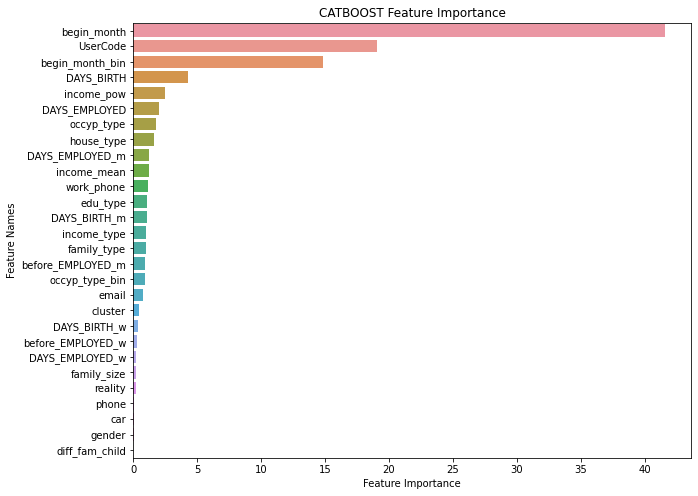

In [125]:
plot_feature_importance(grid_search_cat.best_estimator_.feature_importances_,x_test.columns,'CATBOOST')

### GridSearchCV & LGBM Classifier

In [126]:
# x_train['UserCode_bin'] = x_train['UserCode_bin'].astype('float64')
# x_test['UserCode_bin'] = test_df['UserCode_bin'].astype('float64')

In [127]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
import numpy as np

# LGBMClassifier 모델 객체 생성
model_lgbm = LGBMClassifier()

param_grid = {
    'max_depth': [8],
    'learning_rate': [0.05, 0.1],
    'reg_lambda': [5],
    'min_child_samples': [20, 30],
    'subsample': [0.5, 0.7, 1.0],
}

# GridSearchCV 객체 생성
grid_search_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, cv=n_fold, scoring='neg_log_loss')

# 그리드서치를 사용하여 모델 학습
grid_search_lgbm.fit(x_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best Parameters:", grid_search_lgbm.best_params_)

# 최적 모델로 전체 데이터에 대한 예측 수행
pred_y_lgbm_proba = grid_search_lgbm.predict_proba(x_train)

# 전체 데이터에 대한 Log Loss 계산
train_log_loss = log_loss(y_train, pred_y_lgbm_proba)
print(f'Log Loss: {train_log_loss:.6f}')

Best Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'min_child_samples': 30, 'reg_lambda': 5, 'subsample': 0.5}
Log Loss: 0.315890


In [128]:
# 결과분석
pred_y_lgbm_proba = grid_search_lgbm.predict_proba(x_test)
pred_y_lgbm = grid_search_lgbm.best_estimator_.predict(x_test)

In [129]:
# 테스트 데이터에 대한 예측 결과 확인
test_log_loss = log_loss(y_test, pred_y_lgbm_proba)
print(f'Test Log Loss Score: {test_log_loss:.6f}')

Test Log Loss Score: 0.395247


In [130]:
# 결과 리포트 출력
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_y_lgbm))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1898
           1       0.50      0.01      0.01       320

    accuracy                           0.86      2218
   macro avg       0.68      0.50      0.47      2218
weighted avg       0.80      0.86      0.79      2218



In [131]:
from sklearn.metrics import recall_score

# y_true: 실제 레이블, y_pred: 예측된 레이블
# average='macro'는 다중 클래스에서 각 클래스의 재현율을 계산한 후 평균을 취합니다.
recall = recall_score(y_test, pred_y_lgbm, average='macro')

print(f'Recall Score: {recall:.6f}')

Recall Score: 0.502598


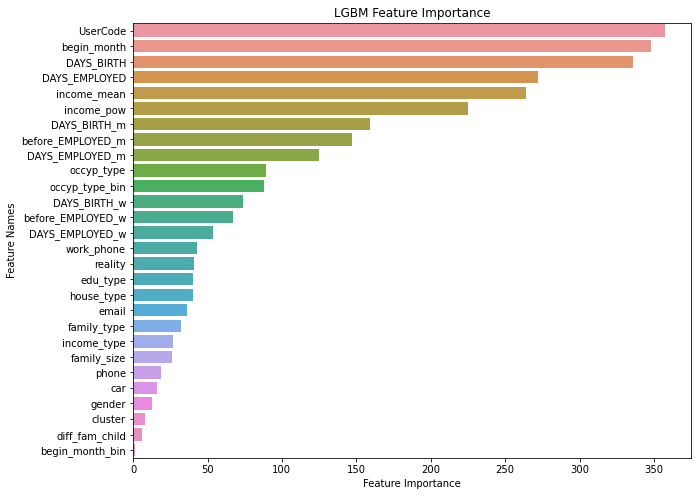

In [132]:
plot_feature_importance(grid_search_lgbm.best_estimator_.feature_importances_,x_test.columns,'LGBM')

### GridSearch & RandomForest

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Log Loss: 0.306438
Test Log Loss +Score: 0.380851
Recall Score: 0.501563


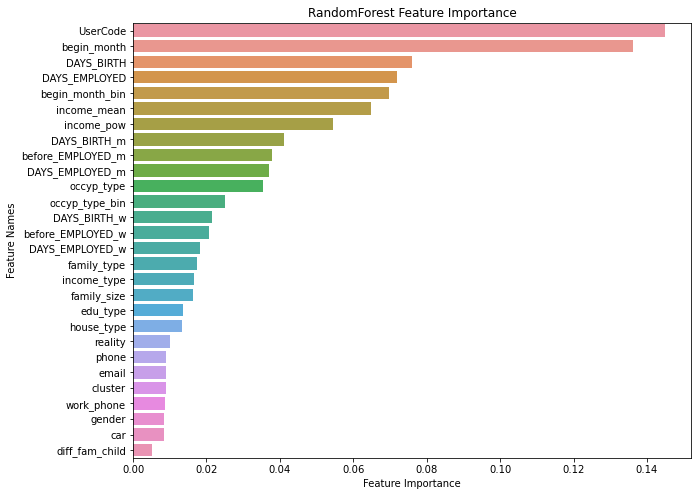

In [133]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier 모델 객체 생성
model_rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
}

# GridSearchCV 객체 생성
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=n_fold, scoring='neg_log_loss')

# 그리드서치를 사용하여 모델 학습
grid_search_rf.fit(x_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best Parameters:", grid_search_rf.best_params_)

# 최적 모델로 전체 데이터에 대한 예측 수행
pred_y_rf_proba = grid_search_rf.predict_proba(x_train)

# 전체 데이터에 대한 Log Loss 계산
train_log_loss = log_loss(y_train, pred_y_rf_proba)
print(f'Log Loss: {train_log_loss:.6f}')


# 결과분석
pred_y_rf_proba = grid_search_rf.predict_proba(x_test)
pred_y_rf = grid_search_rf.best_estimator_.predict(x_test)

# 테스트 데이터에 대한 예측 결과 확인
test_log_loss = log_loss(y_test, pred_y_rf_proba)
print(f'Test Log Loss +Score: {test_log_loss:.6f}')

from sklearn.metrics import recall_score

# y_true: 실제 레이블, y_pred: 예측된 레이블
# average='macro'는 다중 클래스에서 각 클래스의 재현율을 계산한 후 평균을 취합니다.
recall = recall_score(y_test, pred_y_rf, average='macro')

print(f'Recall Score: {recall:.6f}')

plot_feature_importance(grid_search_rf.best_estimator_.feature_importances_,x_test.columns,'RandomForest')


Test Log Loss +Score: 0.380851
Recall Score: 0.501563


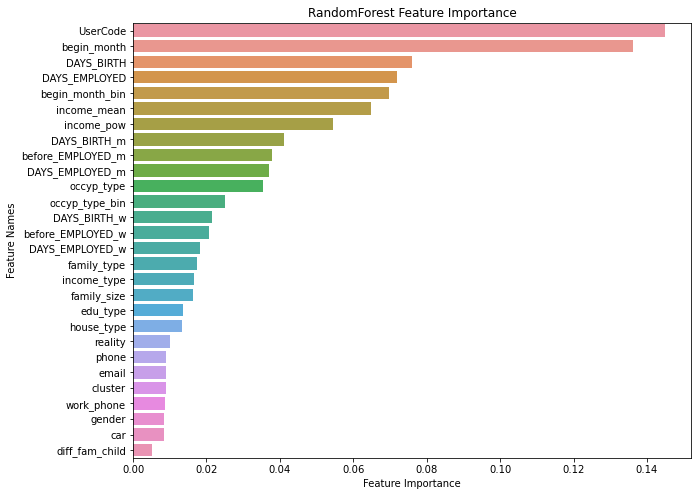

In [134]:
# 테스트 데이터에 대한 예측 결과 확인
test_log_loss = log_loss(y_test, pred_y_rf_proba)
print(f'Test Log Loss +Score: {test_log_loss:.6f}')

from sklearn.metrics import recall_score

# y_true: 실제 레이블, y_pred: 예측된 레이블
# average='macro'는 다중 클래스에서 각 클래스의 재현율을 계산한 후 평균을 취합니다.
recall = recall_score(y_test, pred_y_rf, average='macro')

print(f'Recall Score: {recall:.6f}')

plot_feature_importance(grid_search_rf.best_estimator_.feature_importances_,x_test.columns,'RandomForest')